<a href="https://colab.research.google.com/github/YieldShock13/test-edv/blob/main/Untitled129.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== RAW FILE DATE RANGES ===
SSWJ: 2013-02-12 -> 2025-12-19 rows 3212
SBSW: 2013-02-11 -> 2025-12-19 rows 3236
USDZAR: 2013-01-01 -> 2025-12-19 rows 3384
SPX : 2013-01-02 -> 2025-12-19 rows 3263

=== INNER-JOINED DATE RANGE (SSWJ+SBSW+USDZAR overlap) ===
Start: 2013-02-12 End: 2025-12-19 rows 3128

=== WINSOR DIAGNOSTICS (LEG RETURNS) ===
Winsor rule: level=0.95, upside_only=True (cap at 95th percentile only)
            name     n   lo        hi  n_lo_clip  n_hi_clip       p01  \
0  SA_ret_oo_raw  3127 -inf  0.065714          0        157 -0.098691   
1  SA_ret_oo_win  3127 -inf  0.065681          0        157 -0.098691   
2  US_ret_oo_raw  3127 -inf  0.063733          0        157 -0.092282   
3  US_ret_oo_win  3127 -inf  0.063715          0        157 -0.092282   

       p025       p05       p50       p95      p975       p99  
0 -0.073595 -0.058122  0.000632  0.065714  0.081532  0.099902  
1 -0.073595 -0.058122  0.000632  0.065681  0.065714  0.065714  
2 -0.069693 -0.057903  0.0000

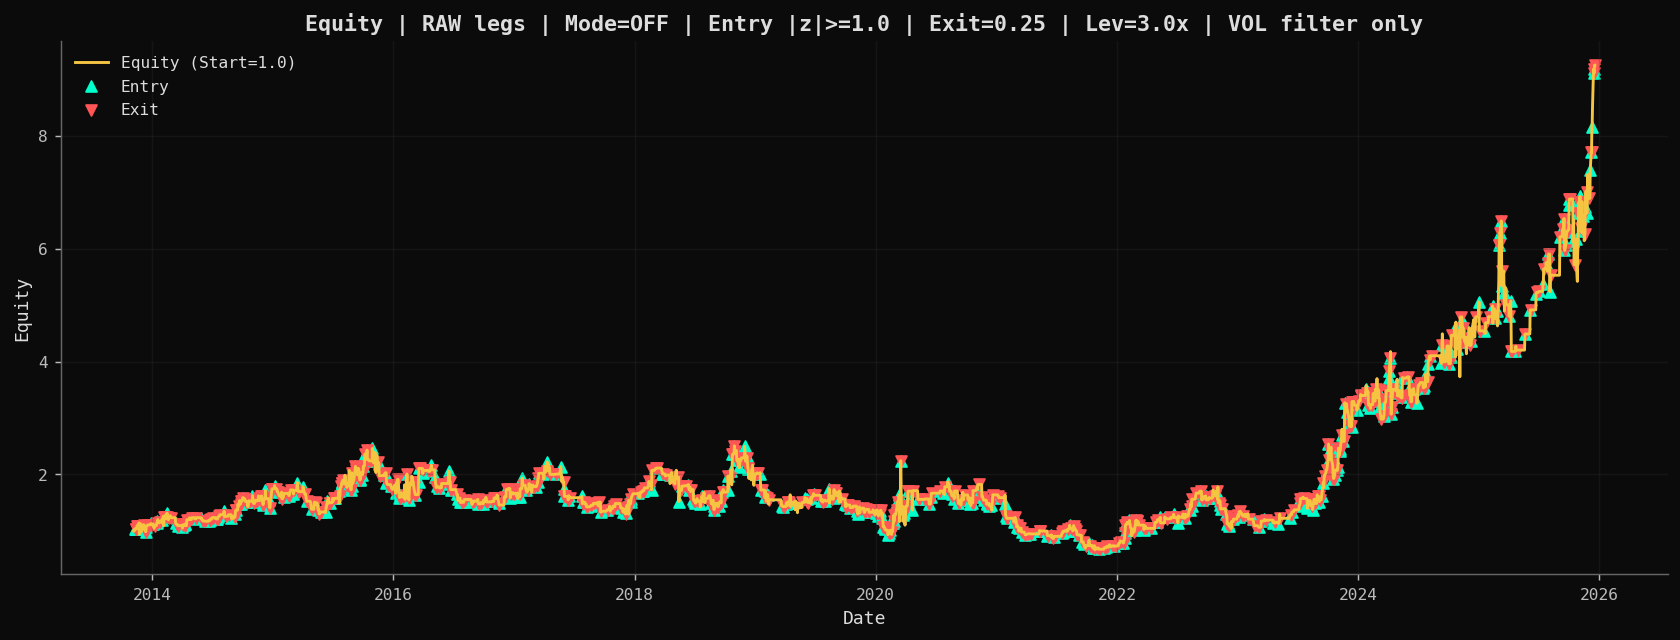

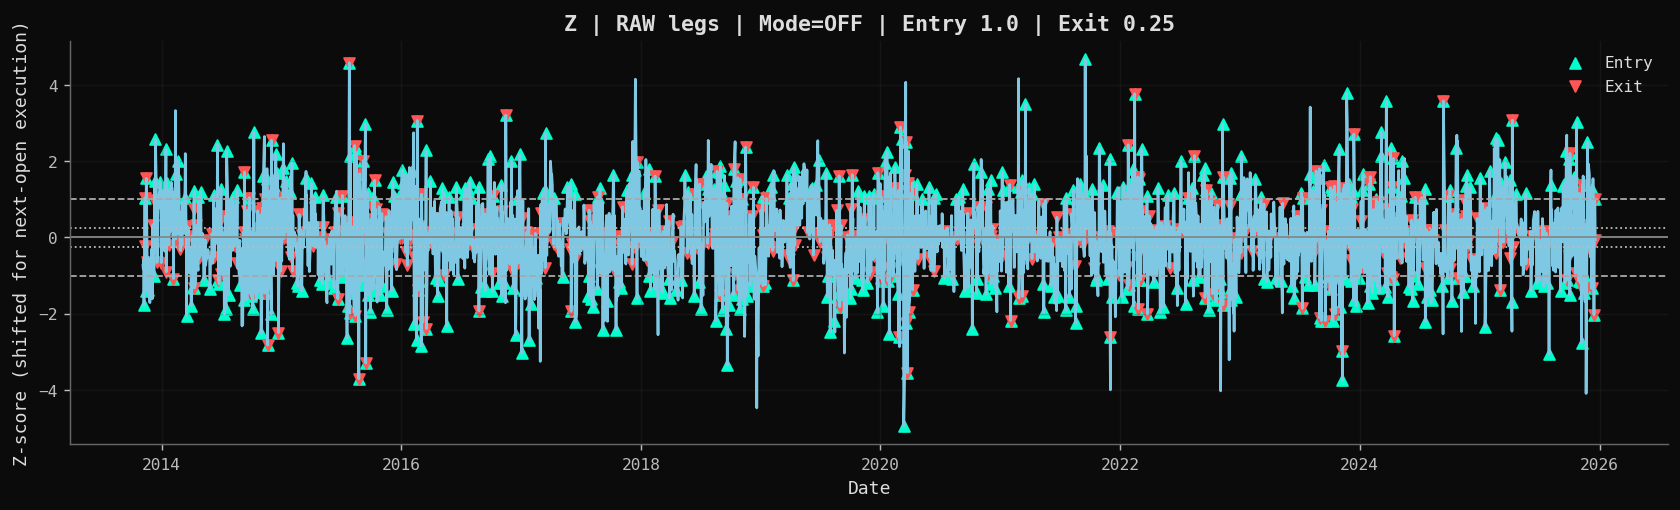

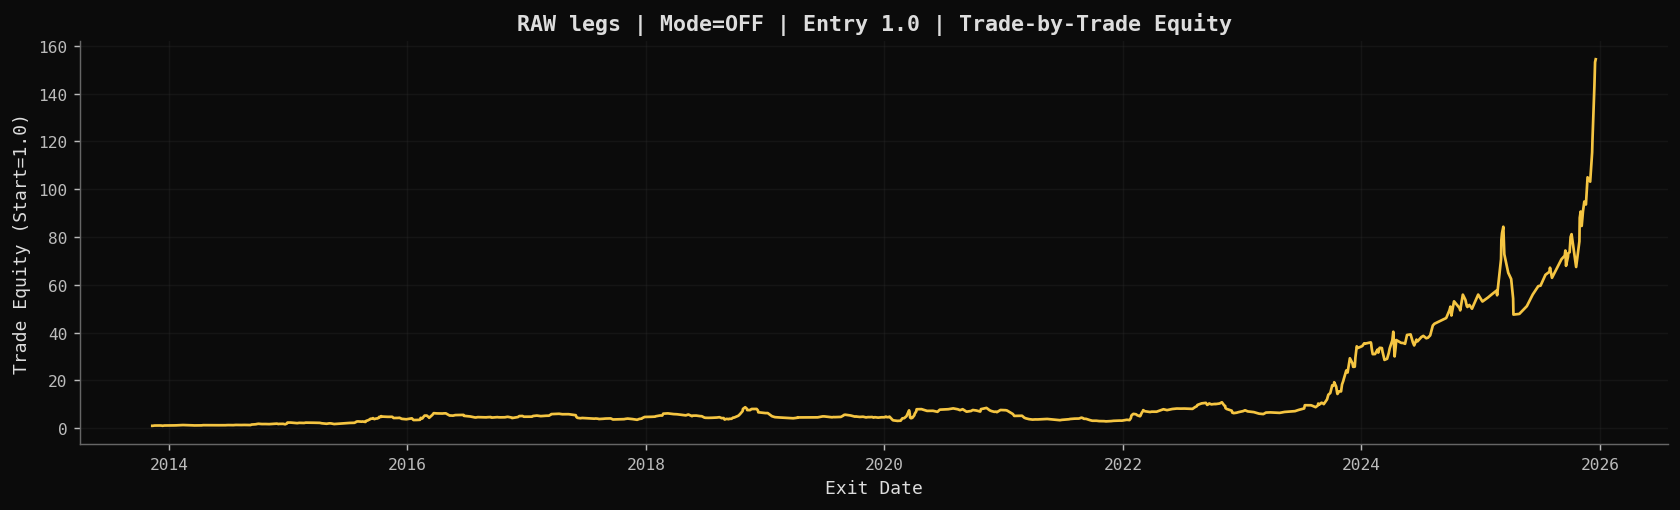

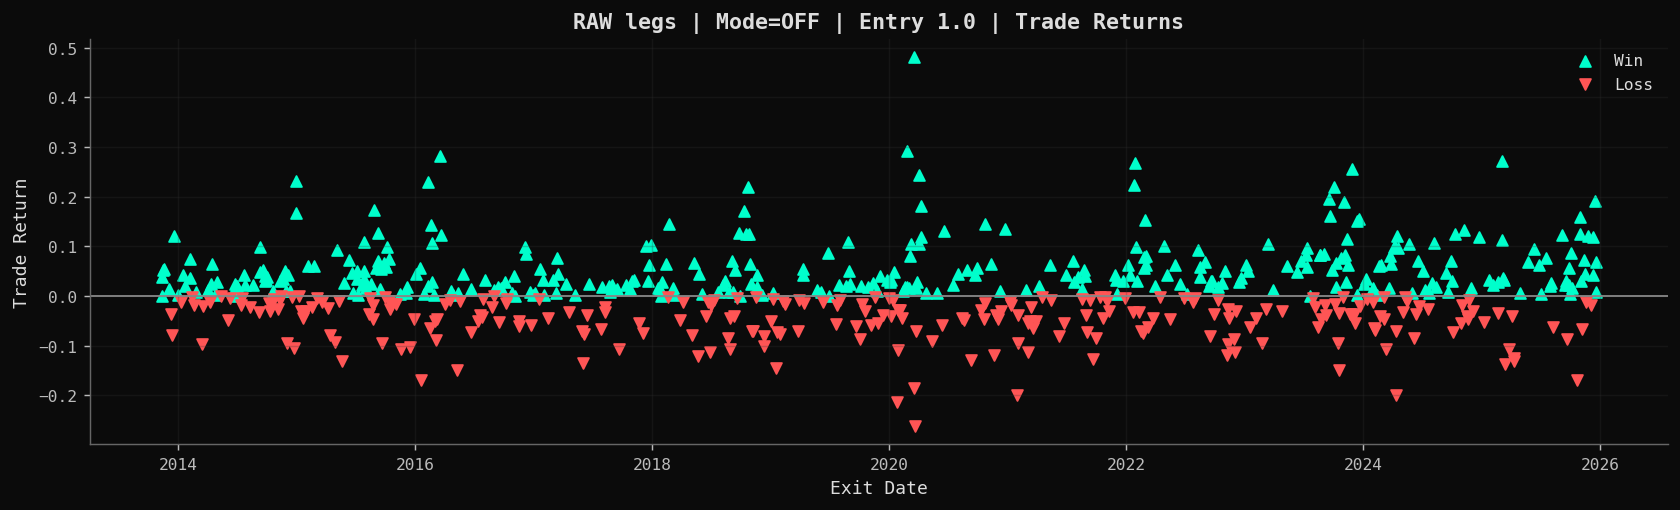

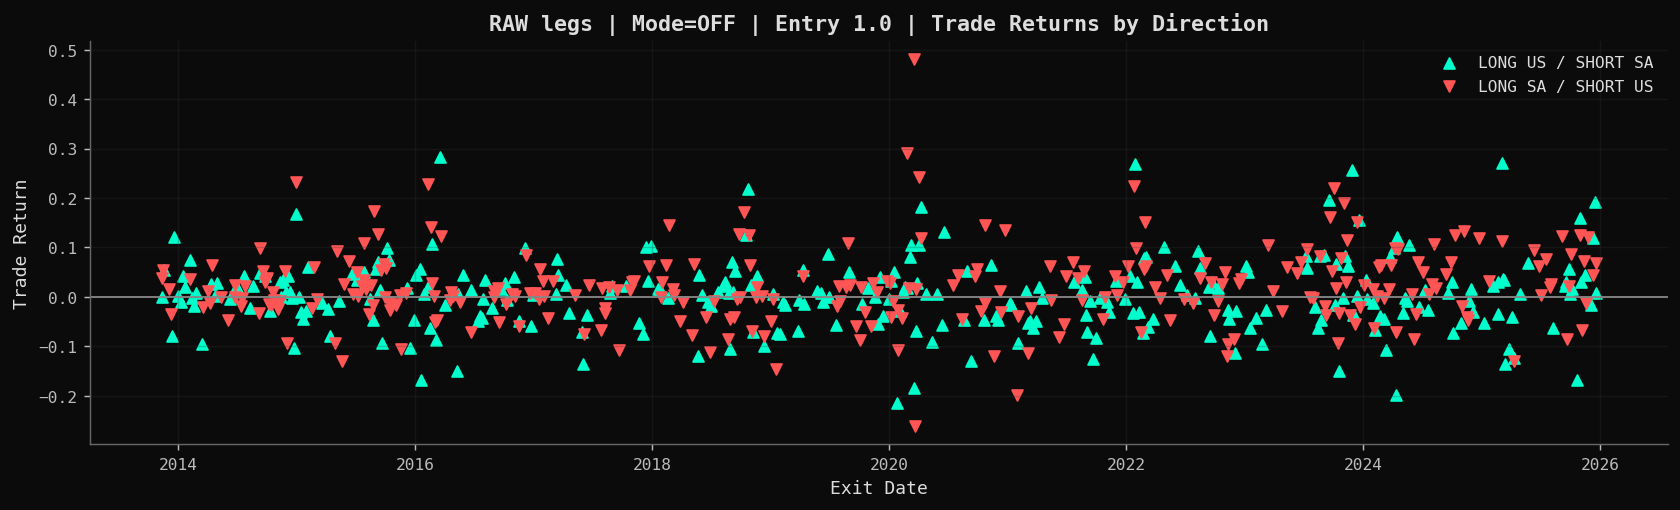

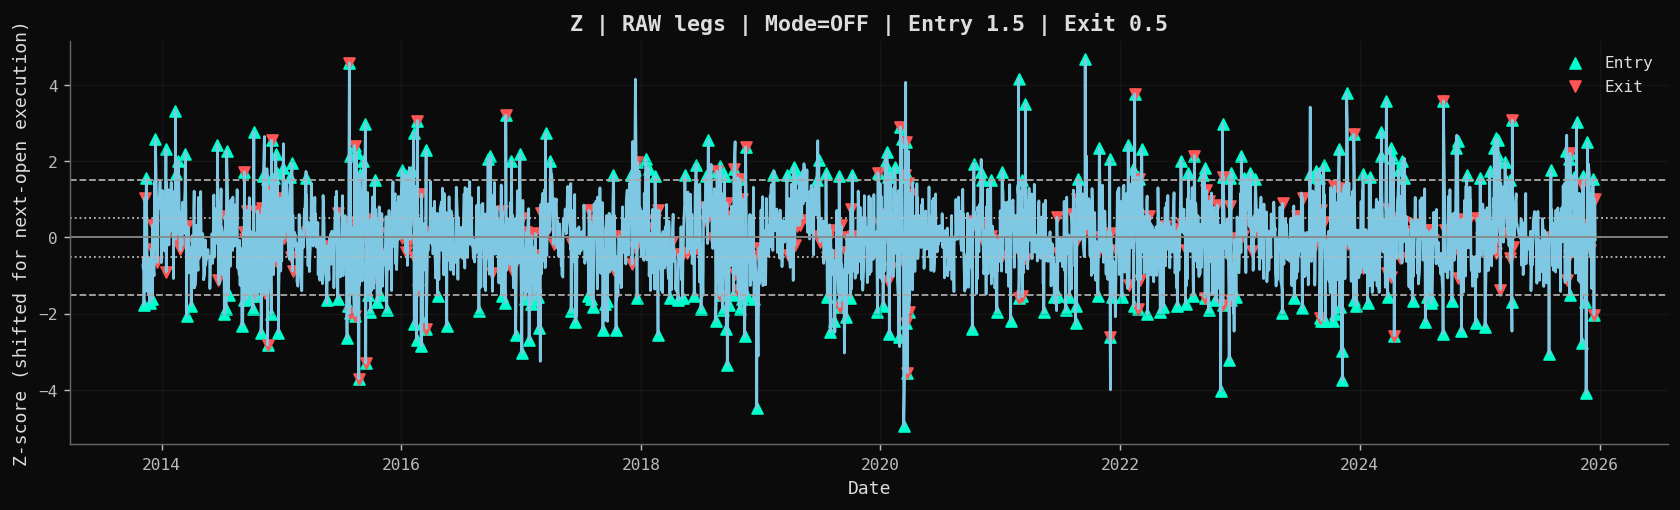

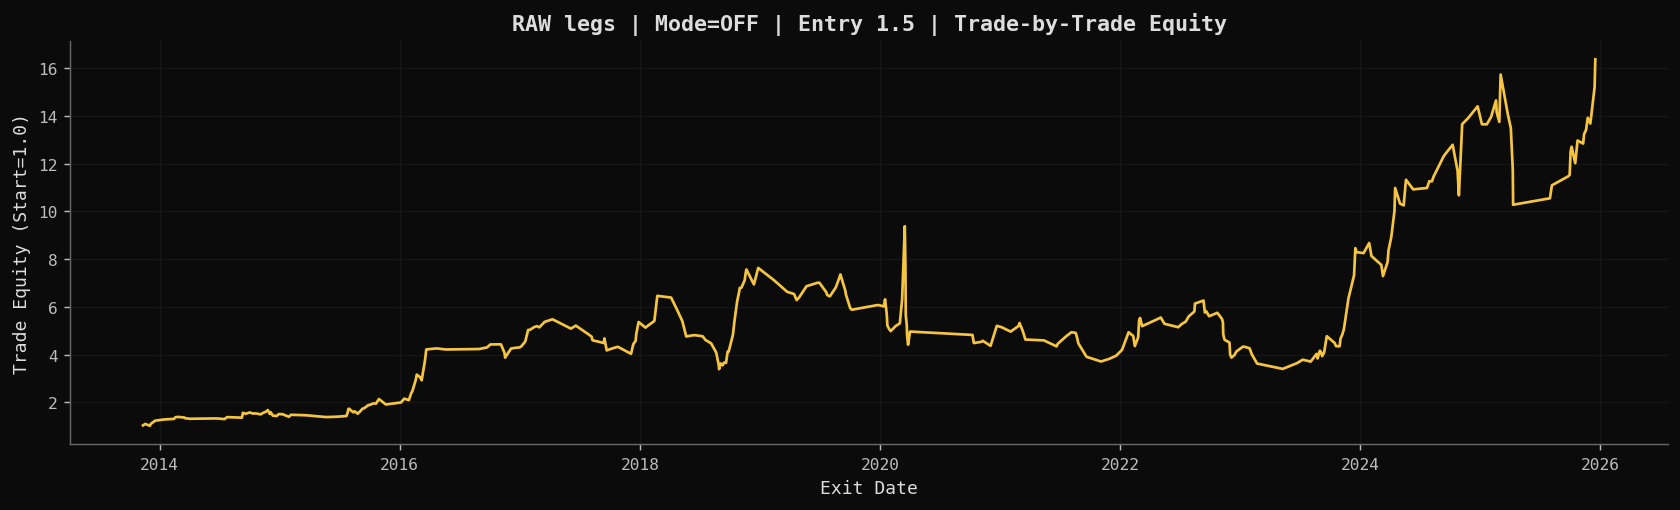

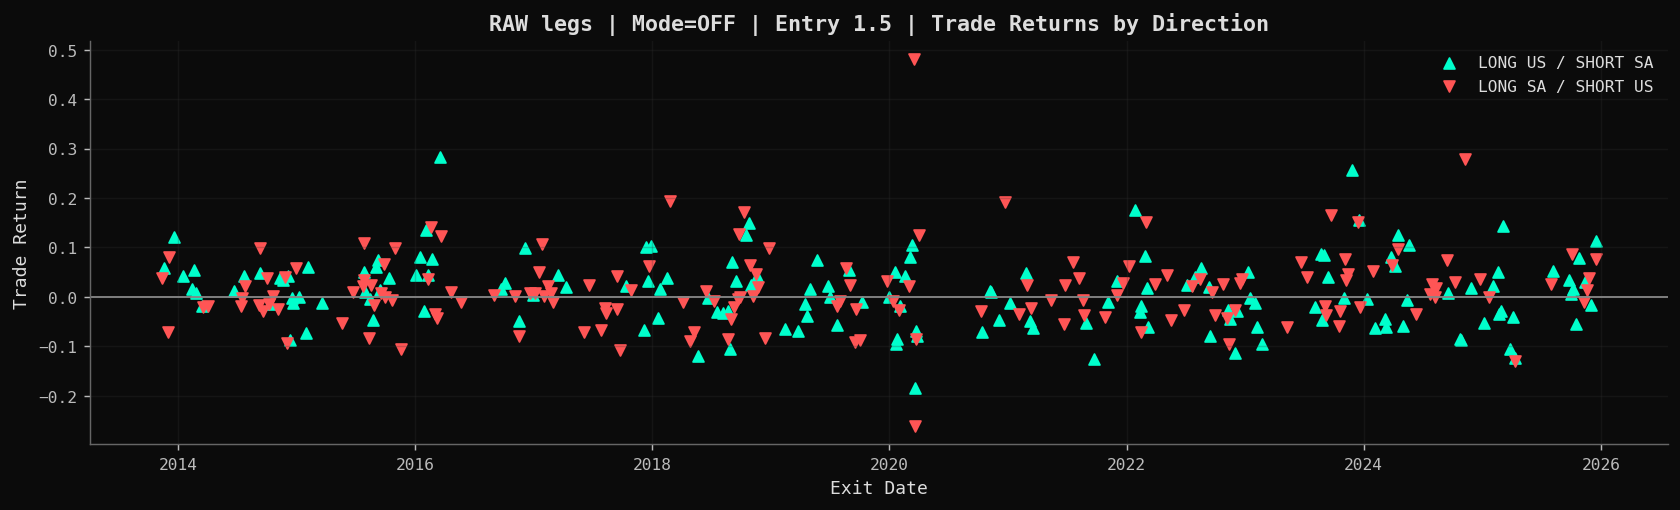

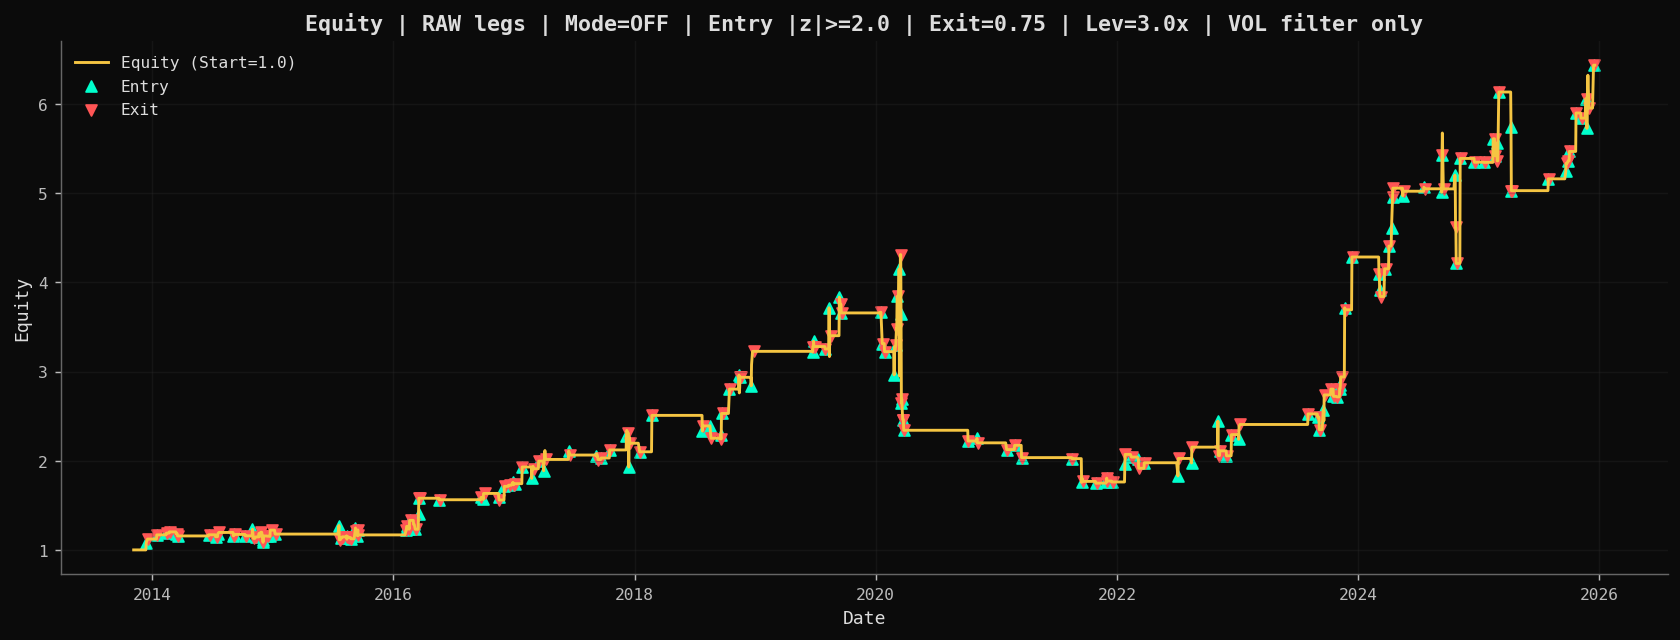

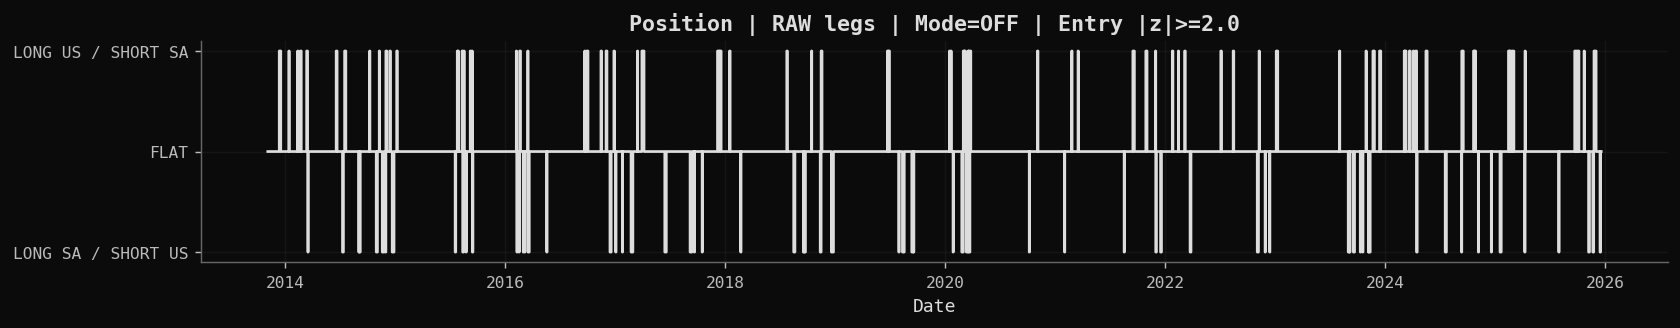

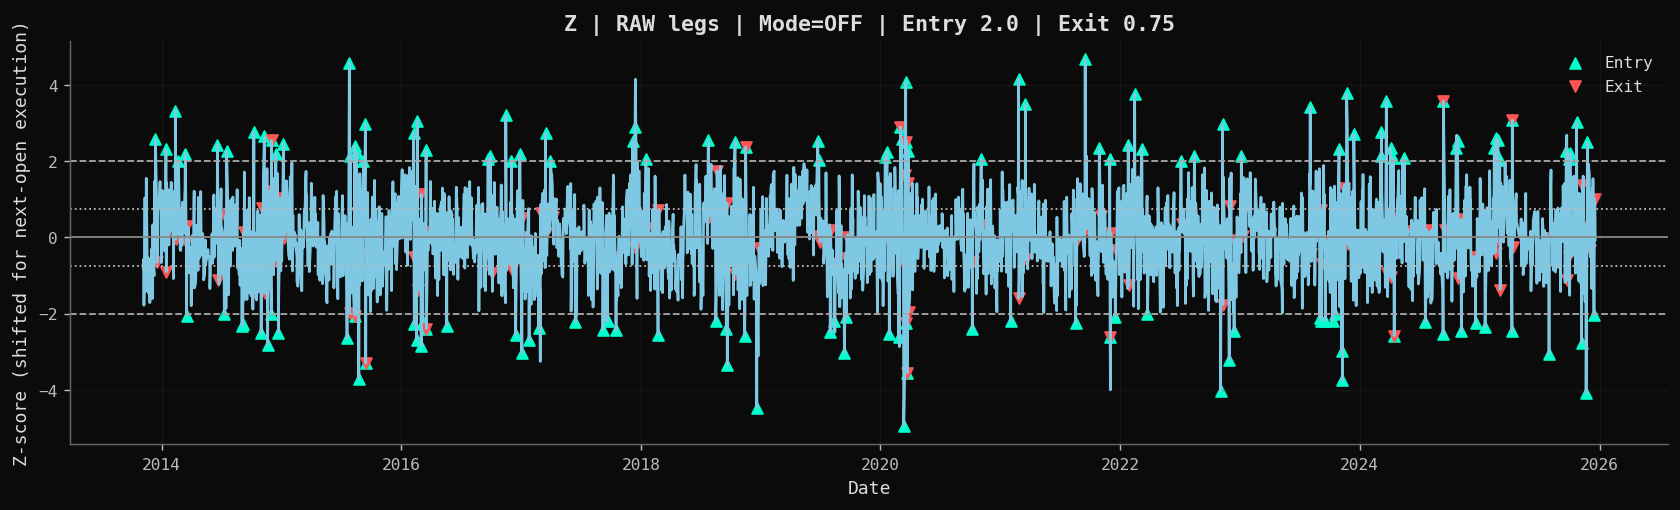

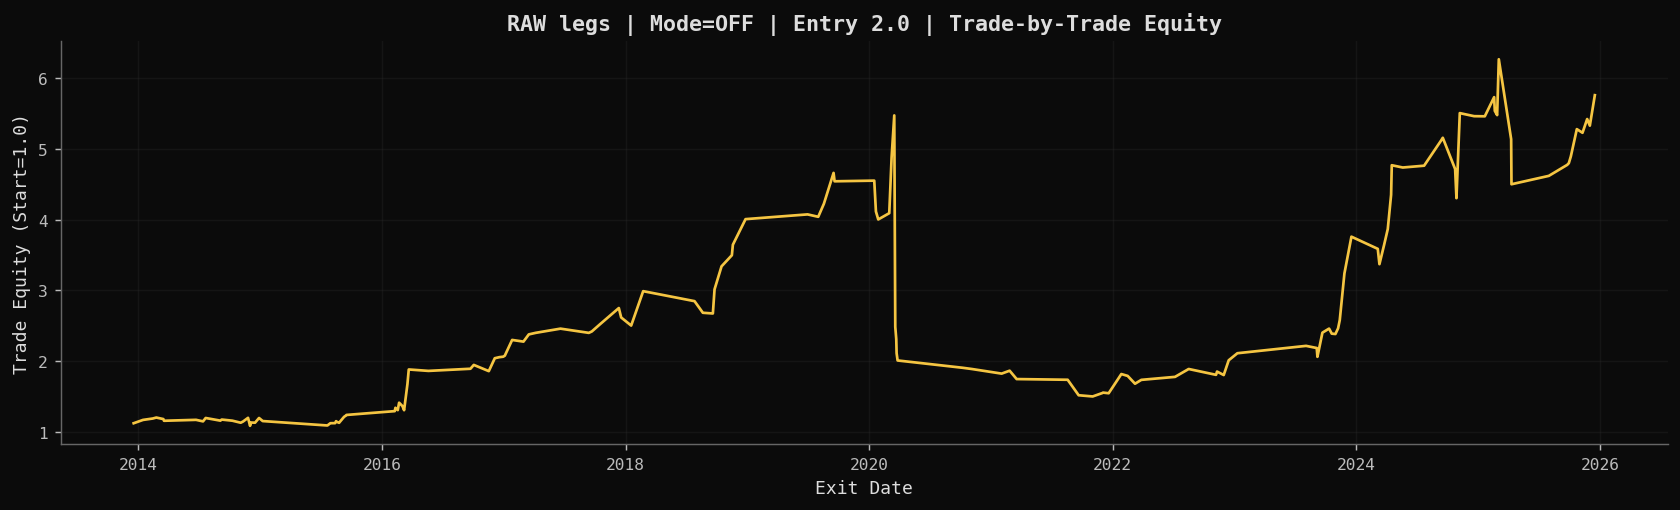

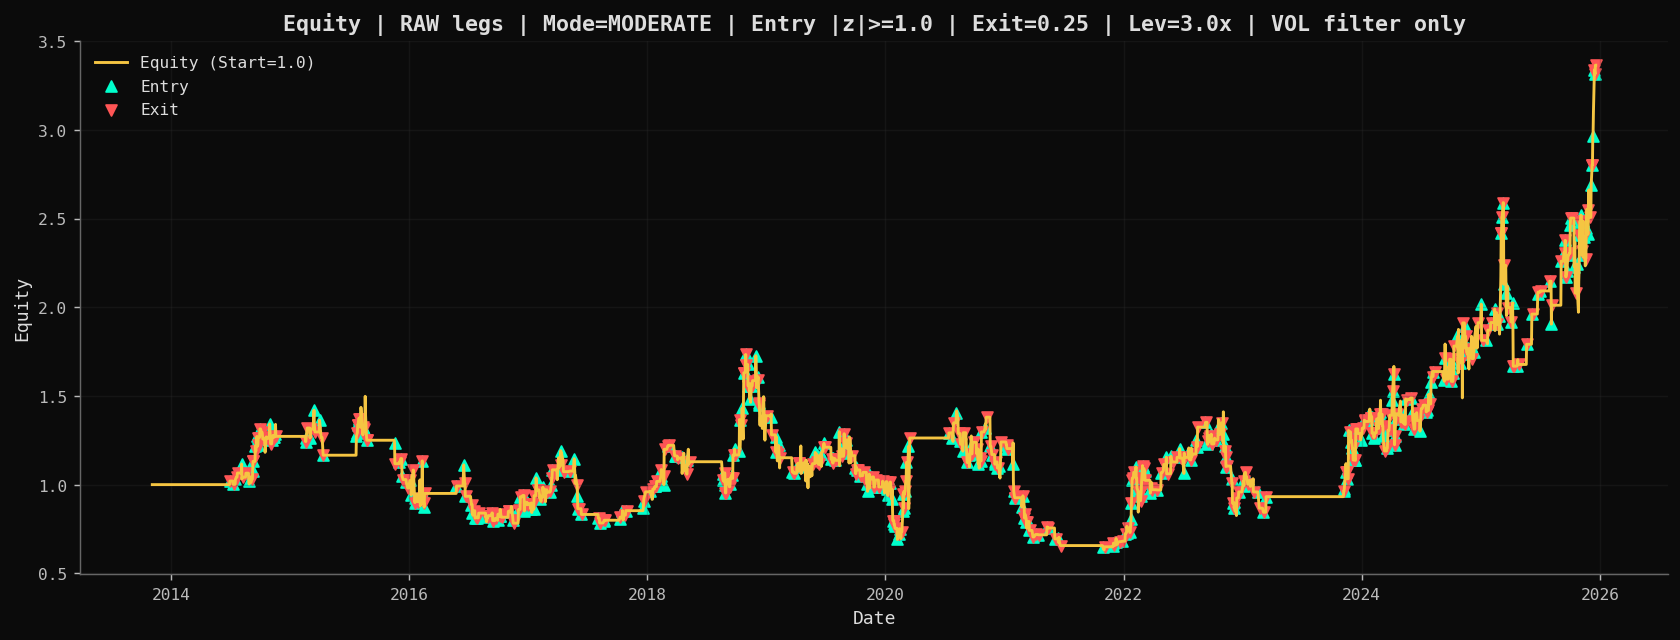

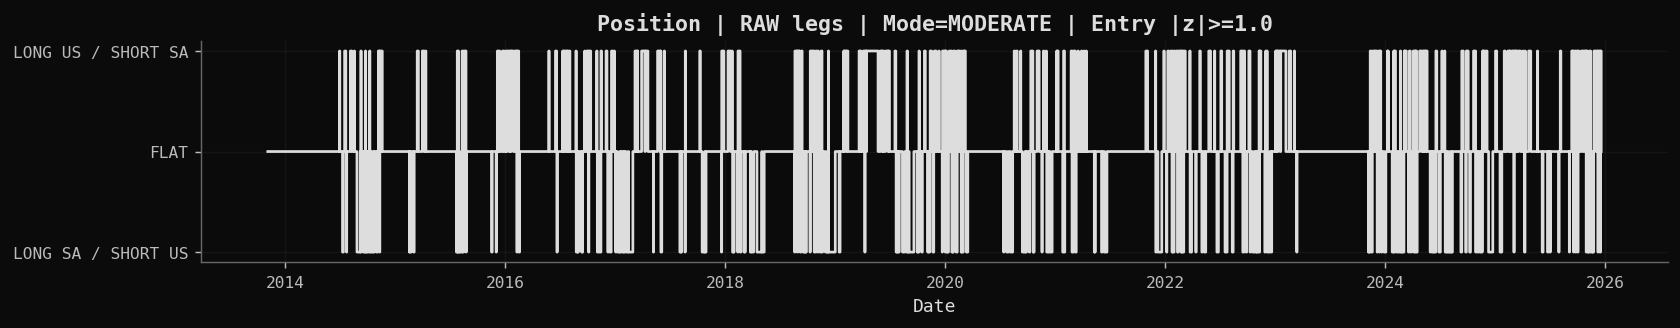

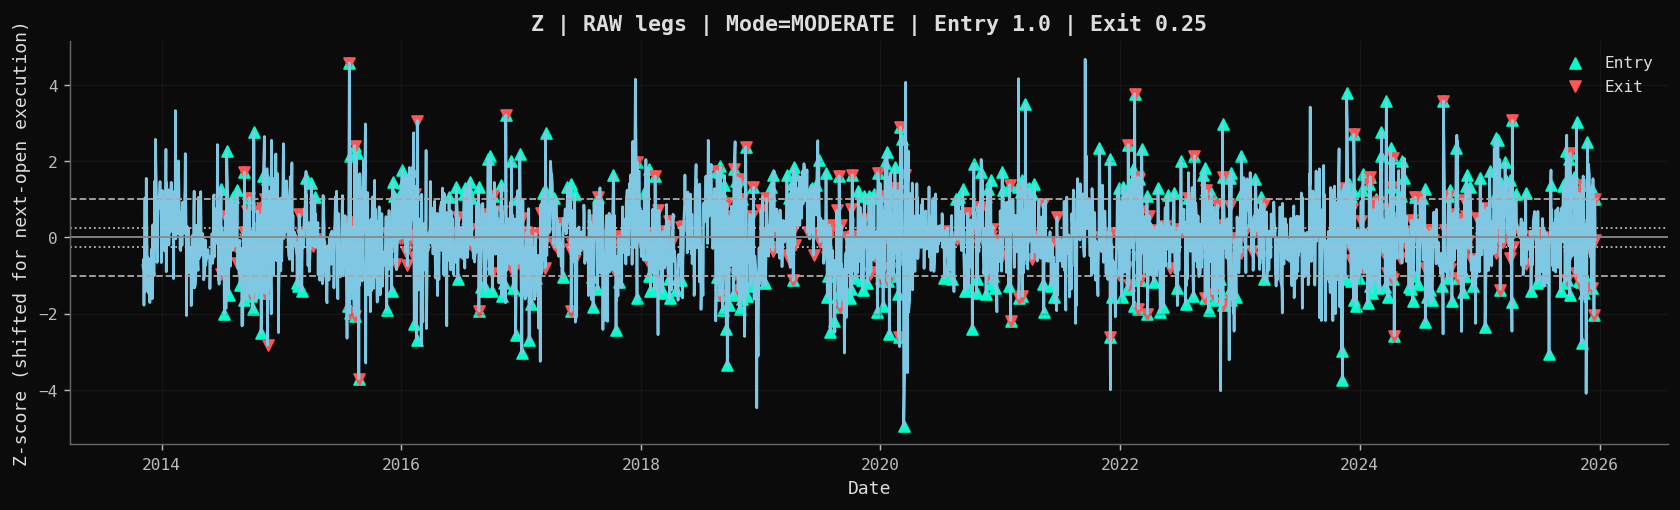

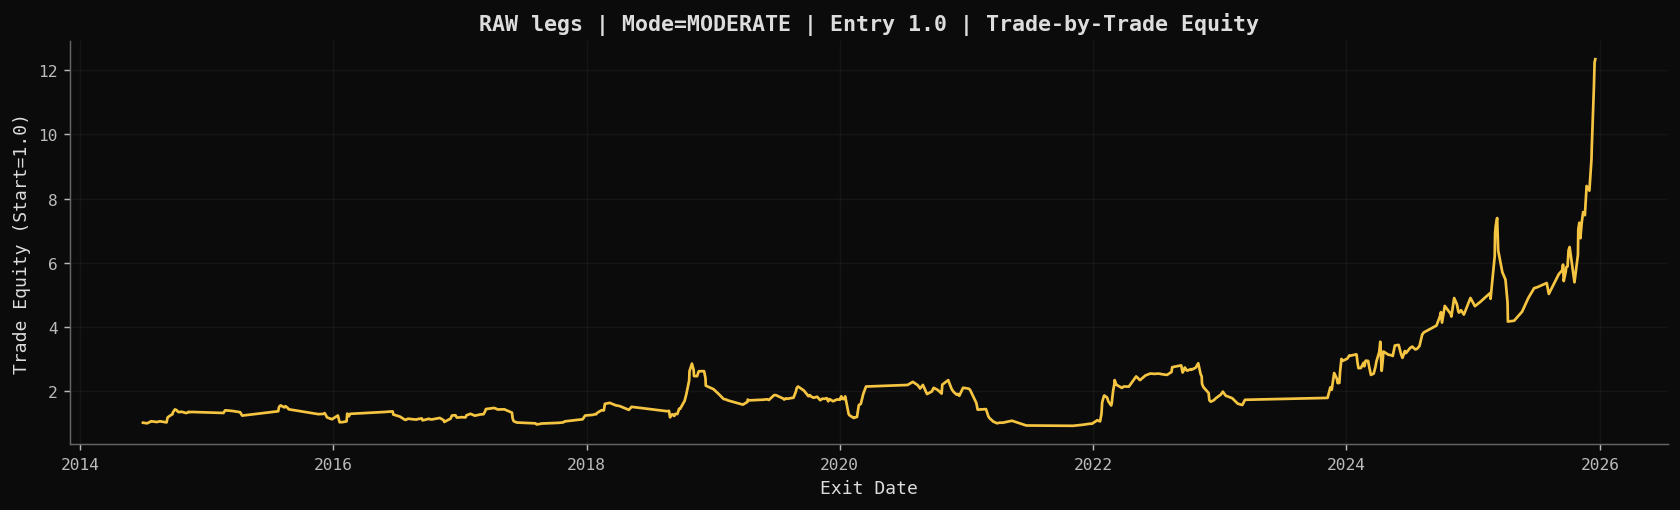

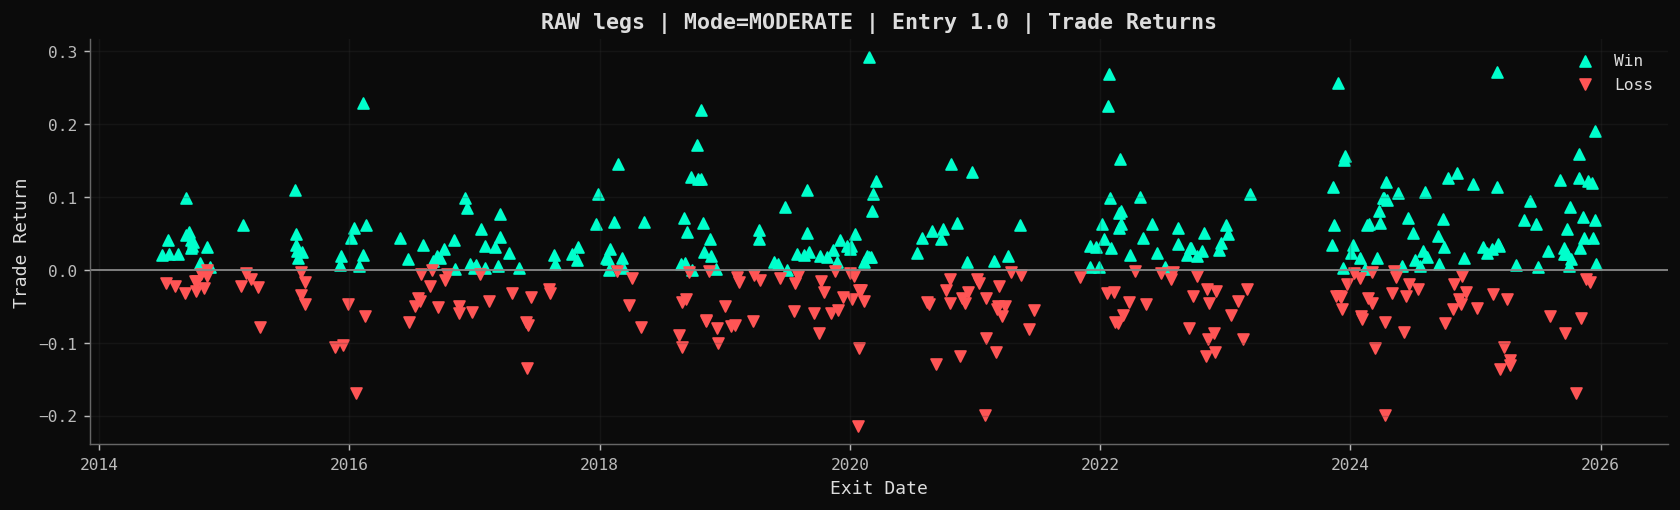

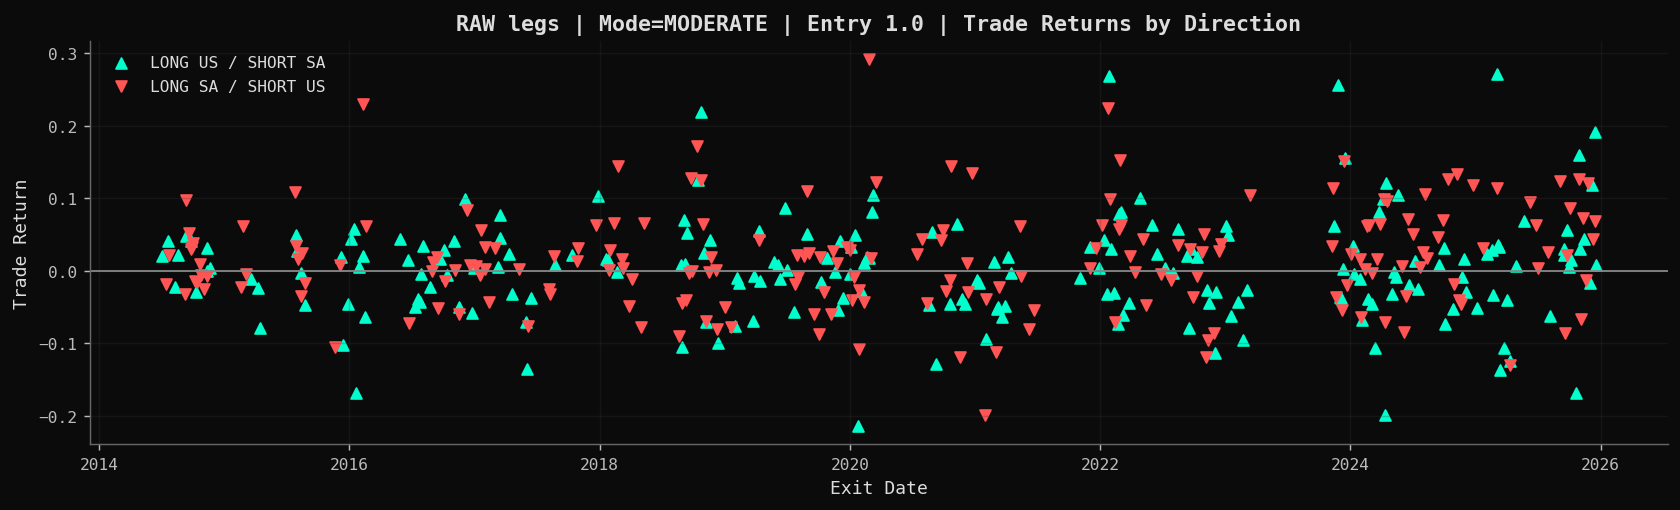

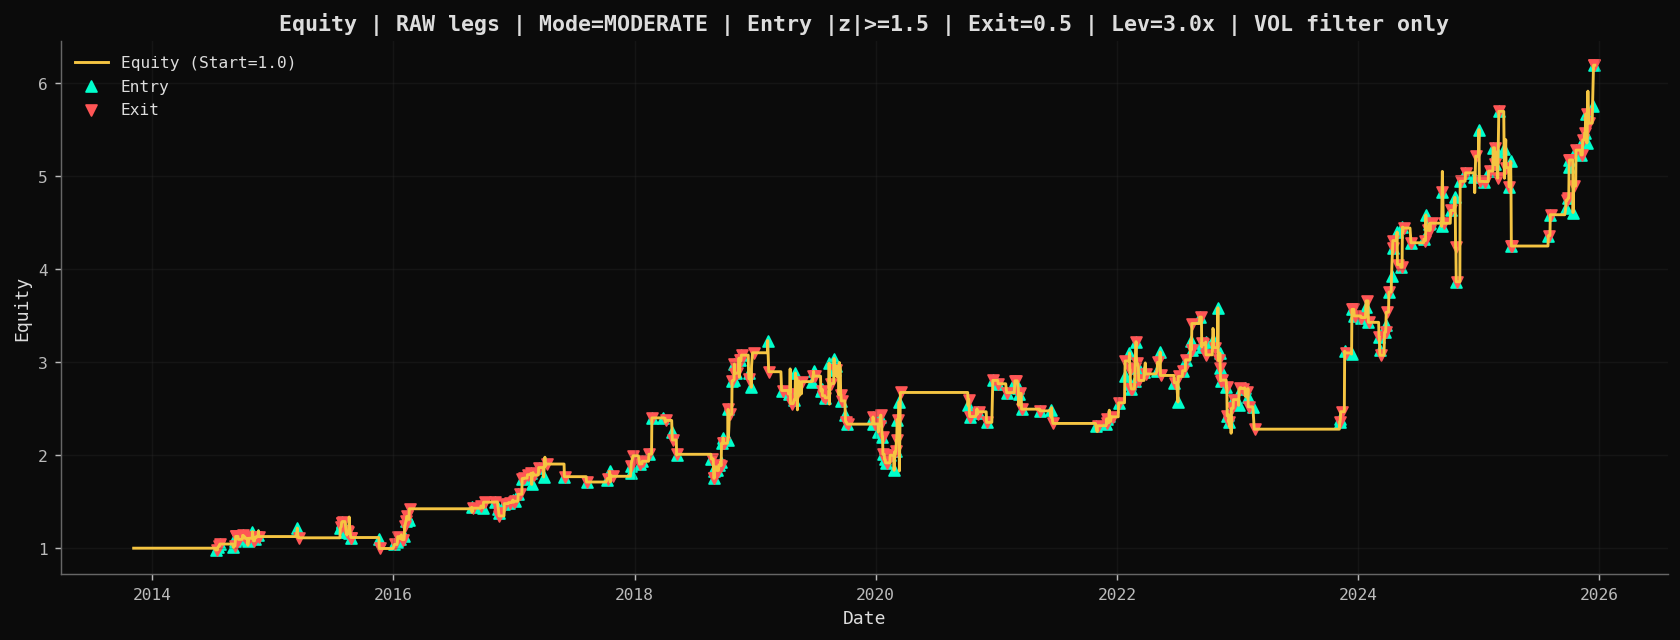

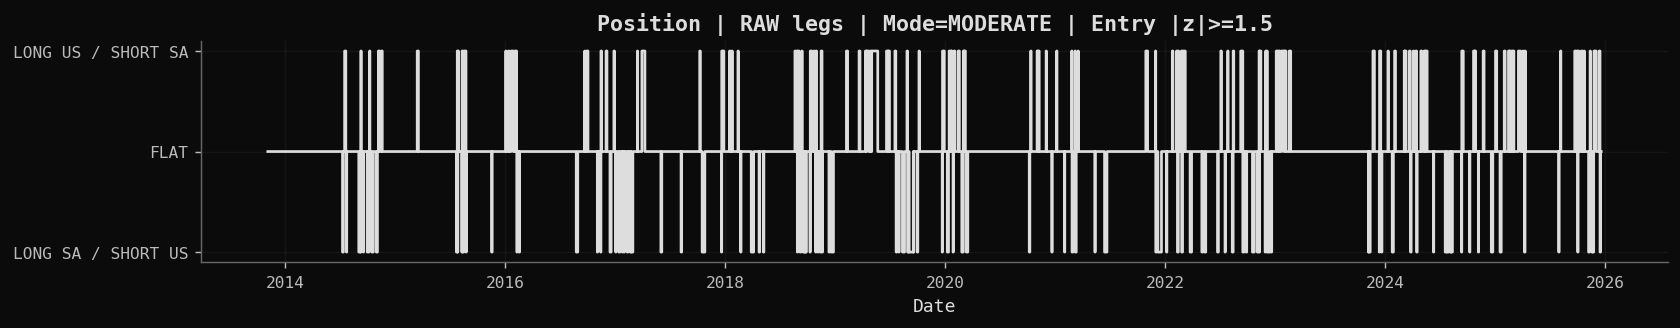

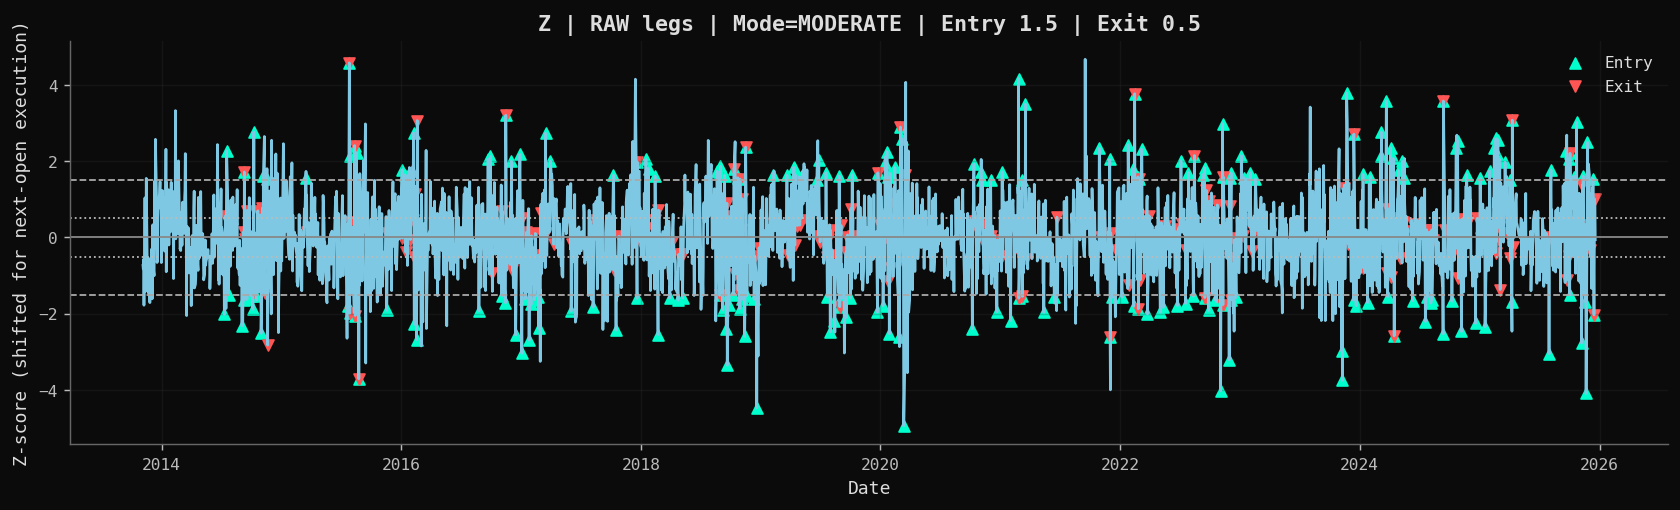

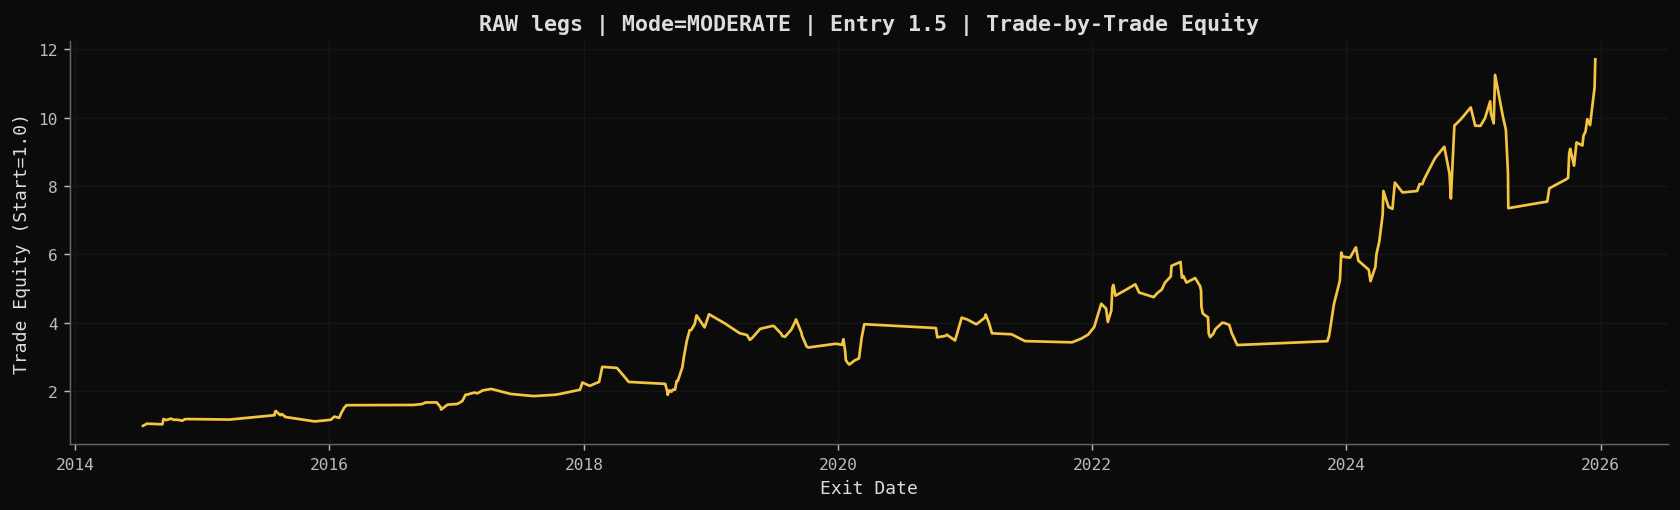

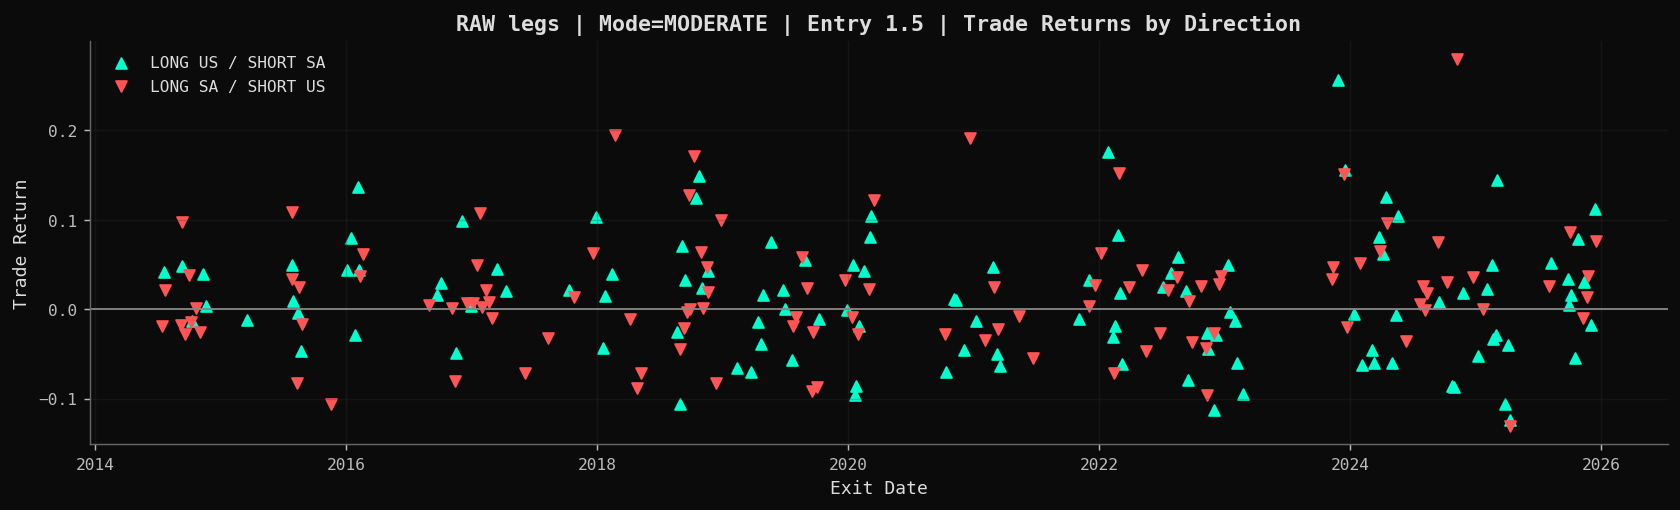

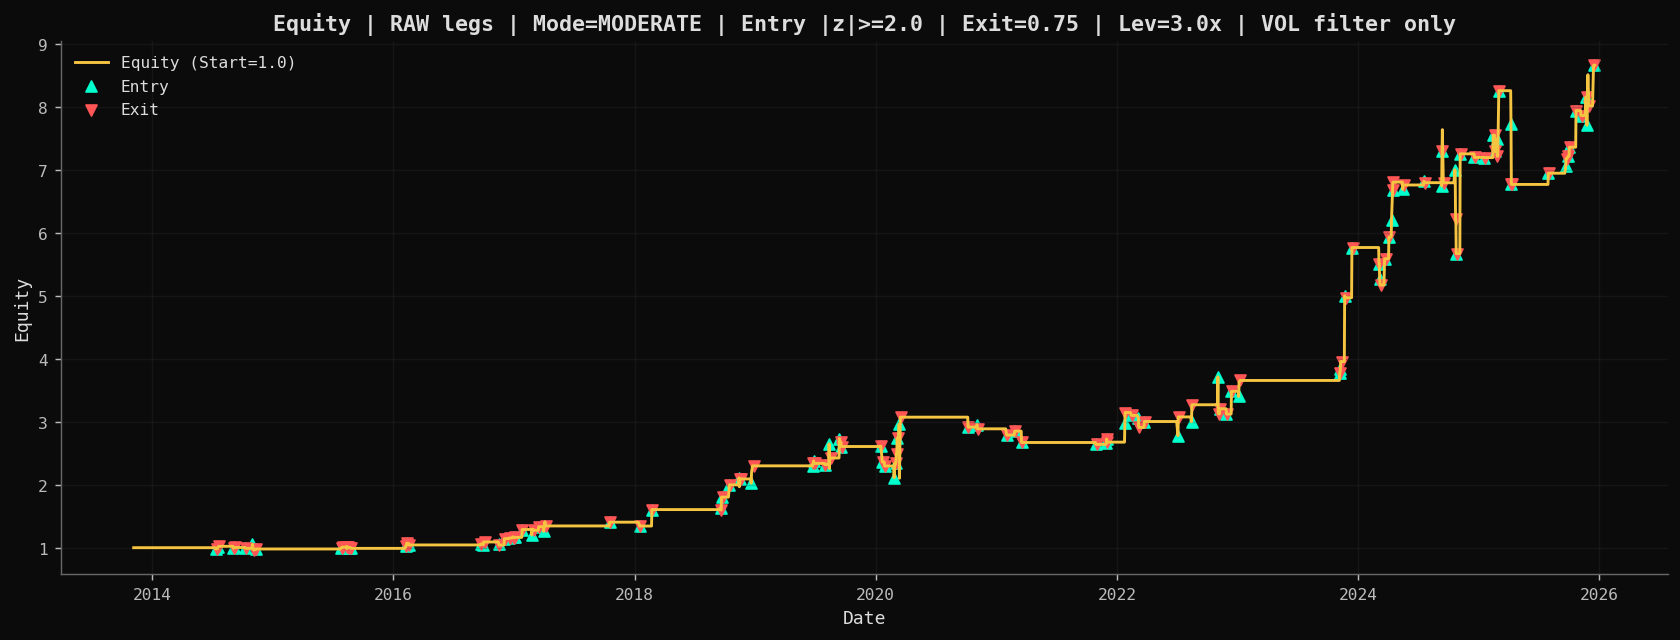

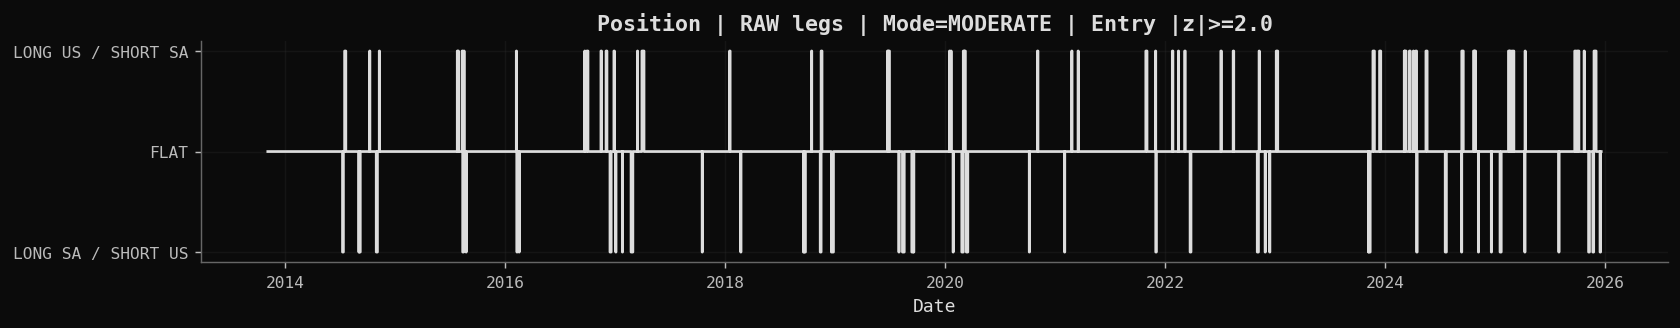

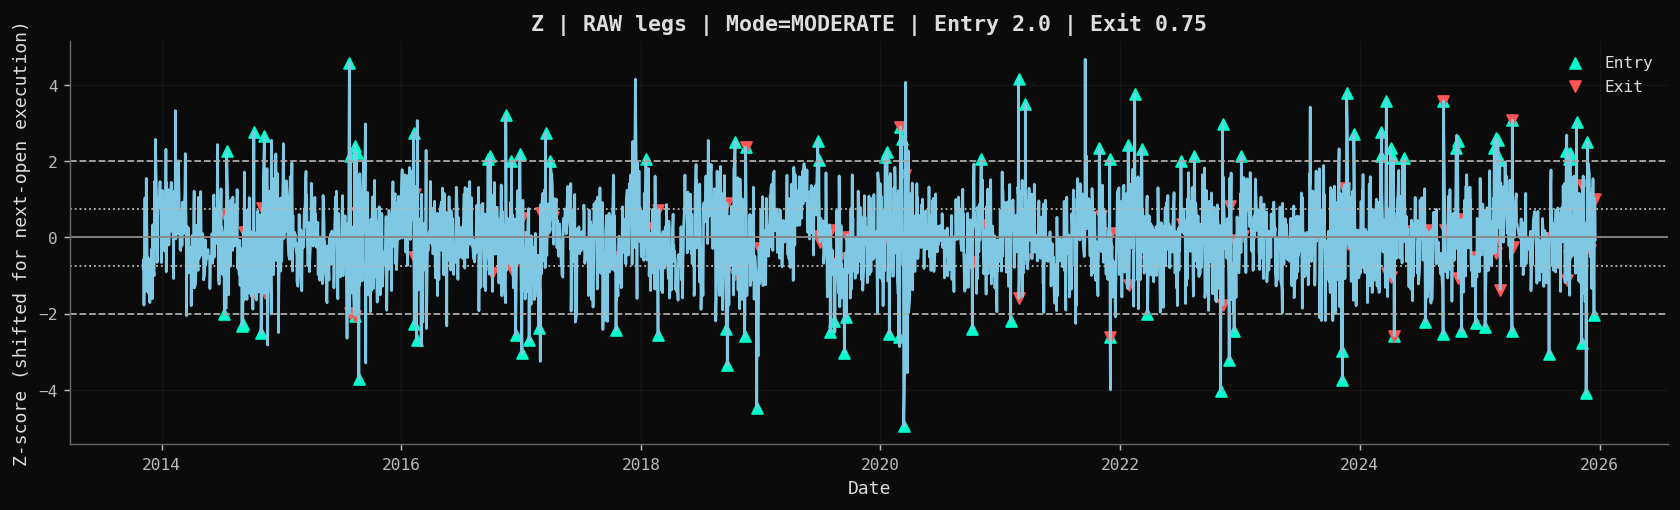

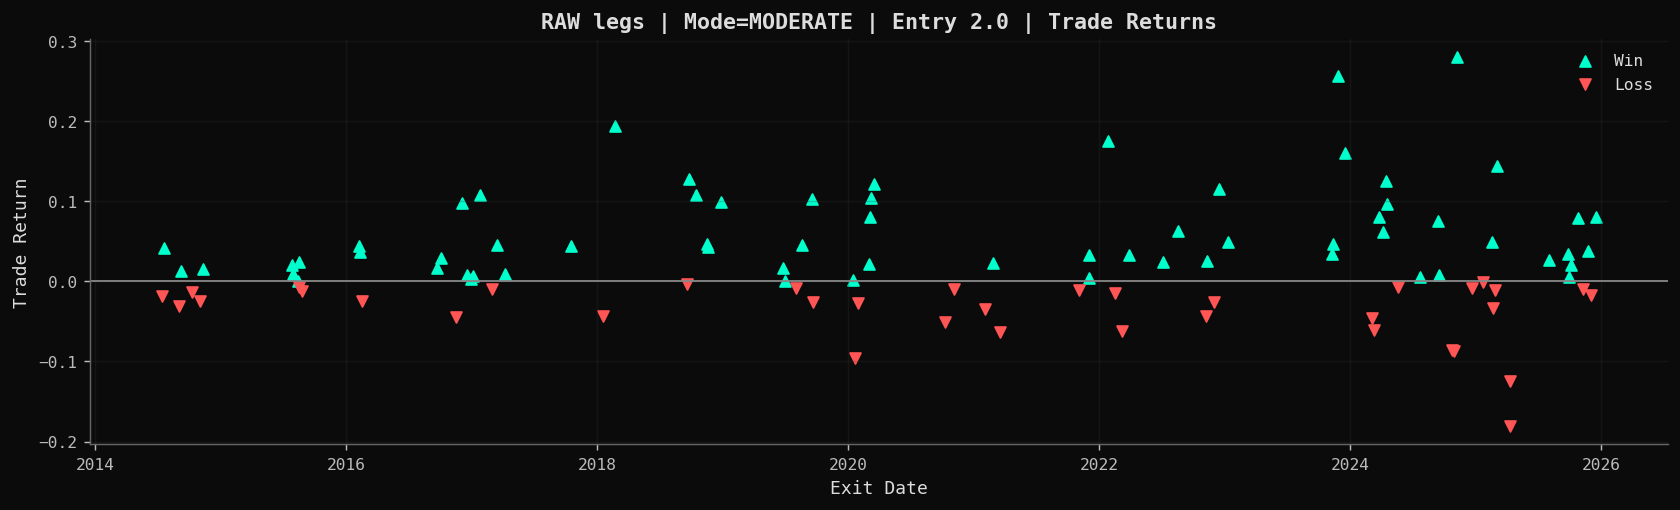

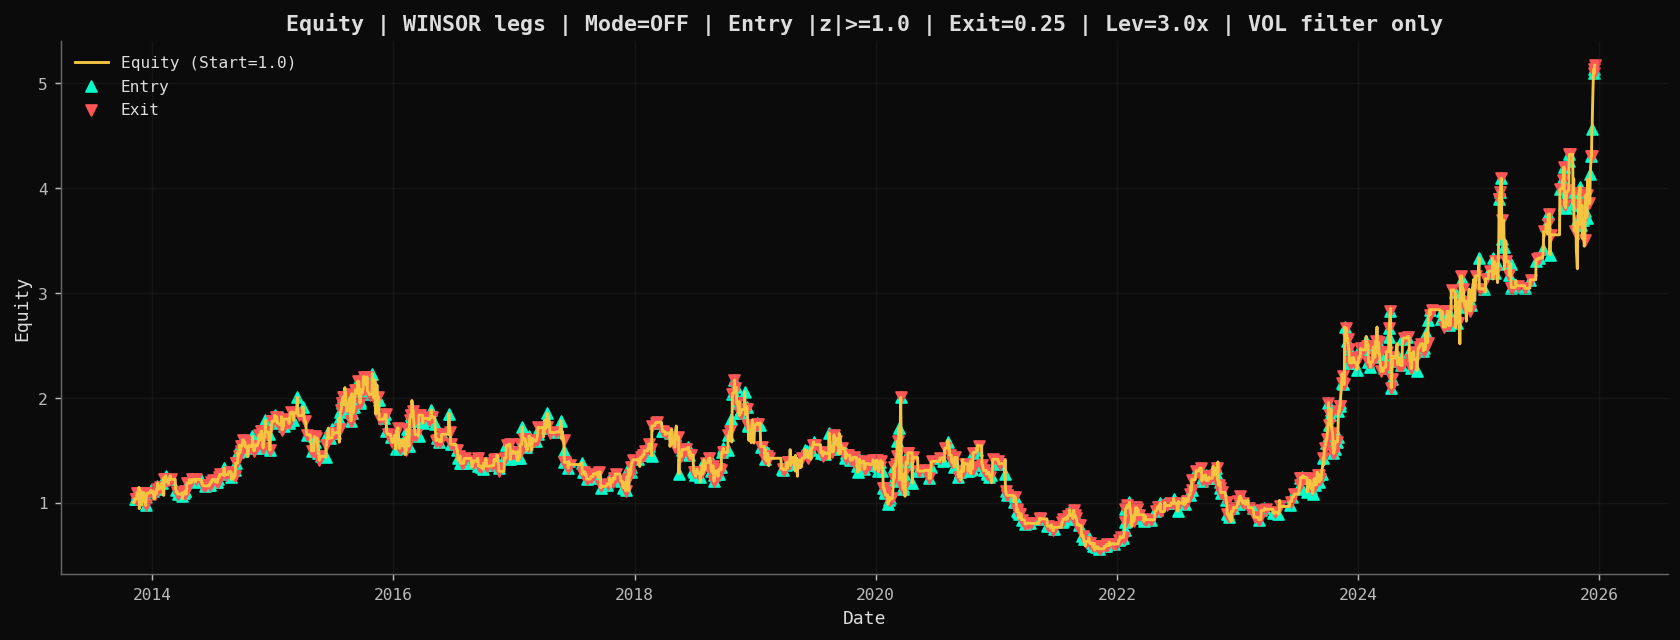

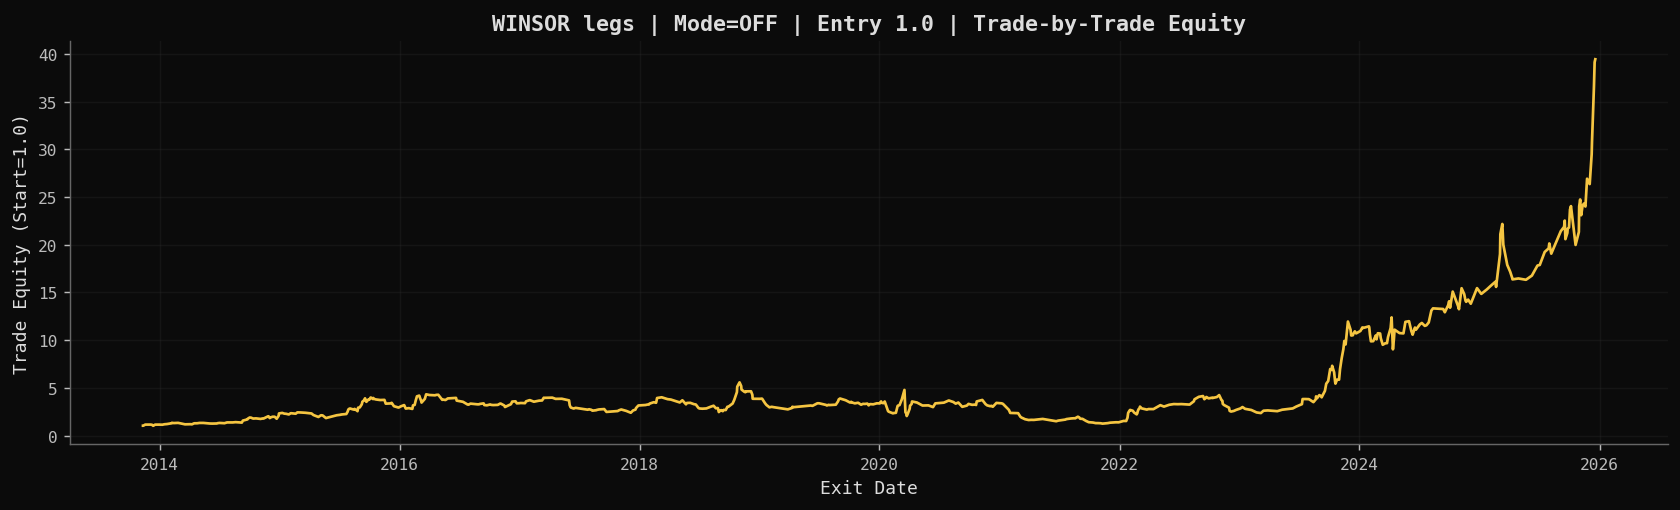

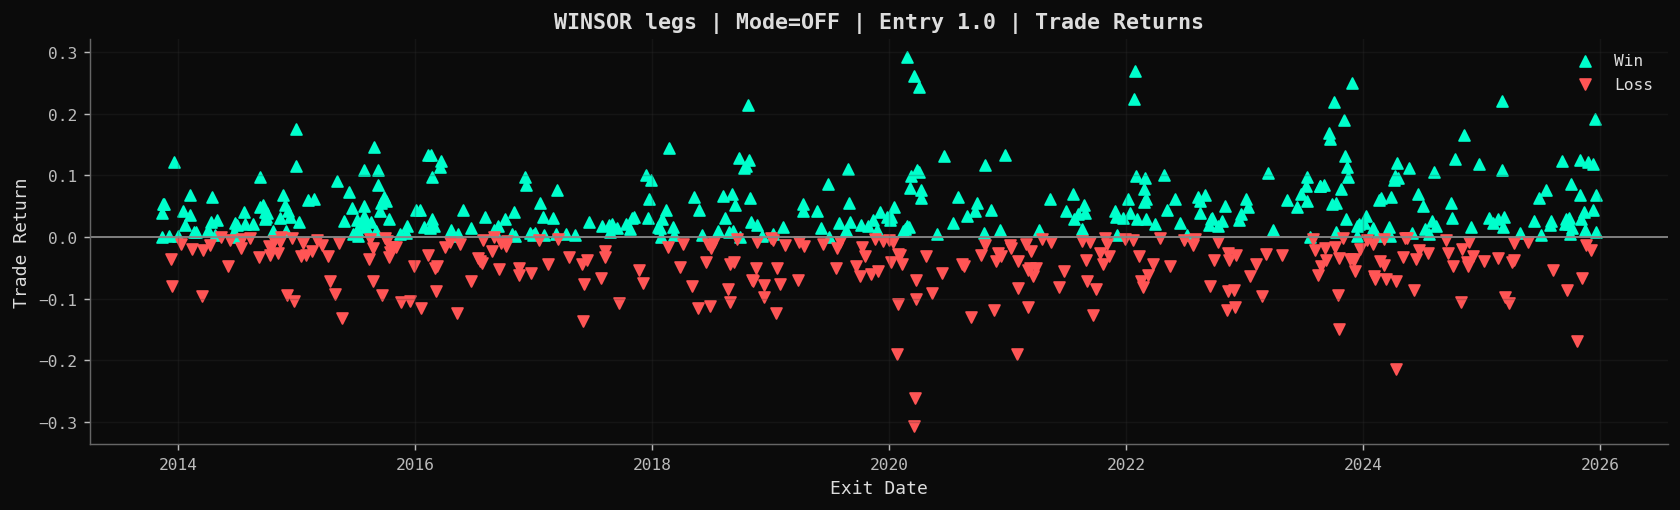

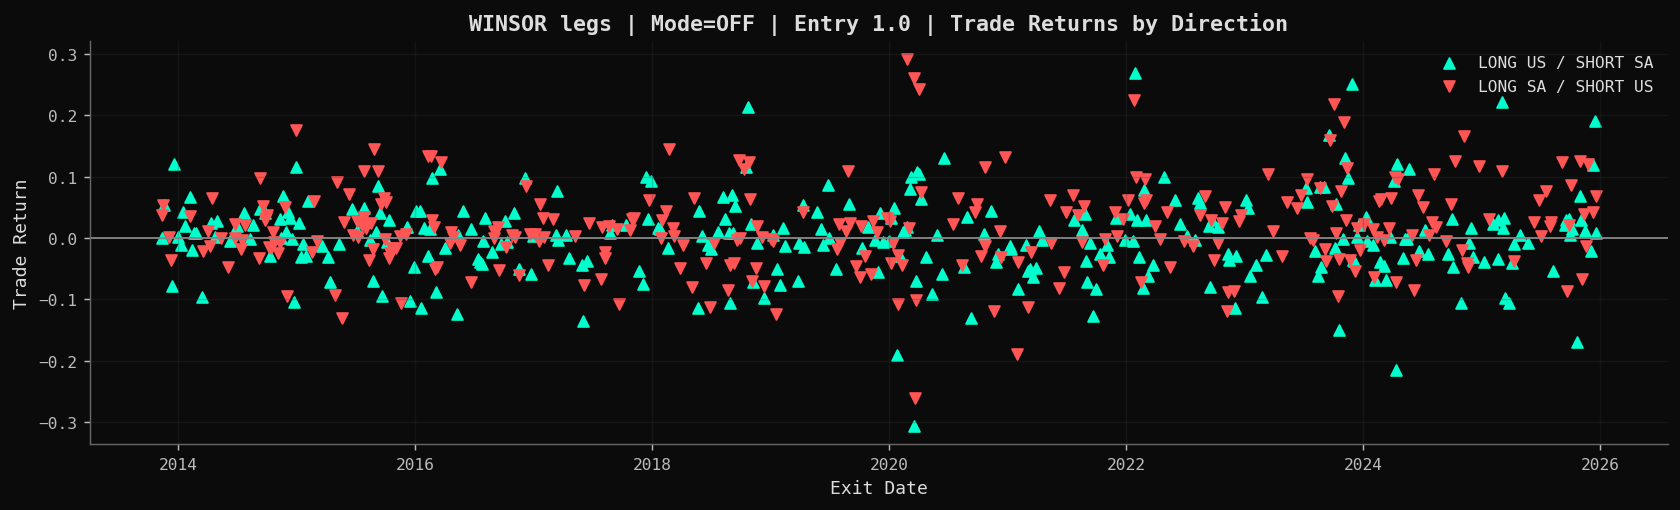

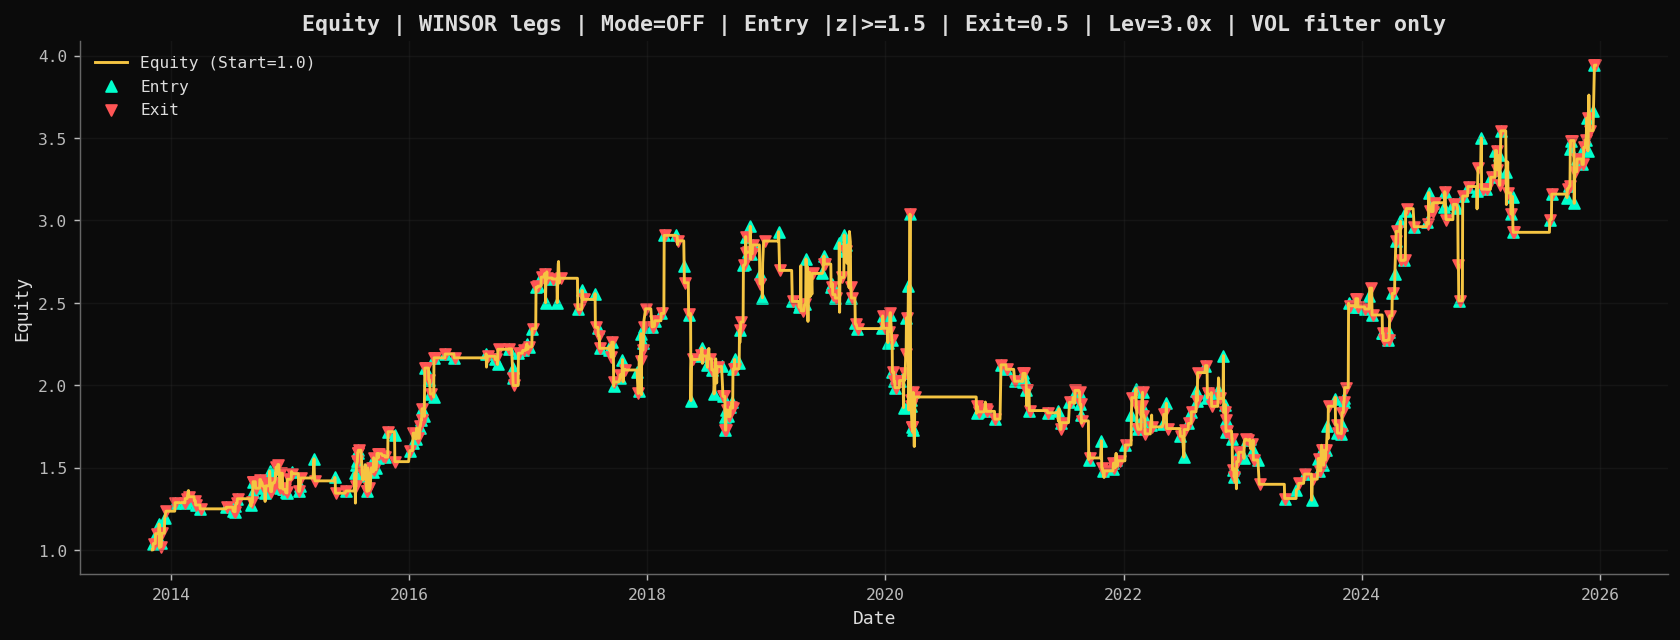

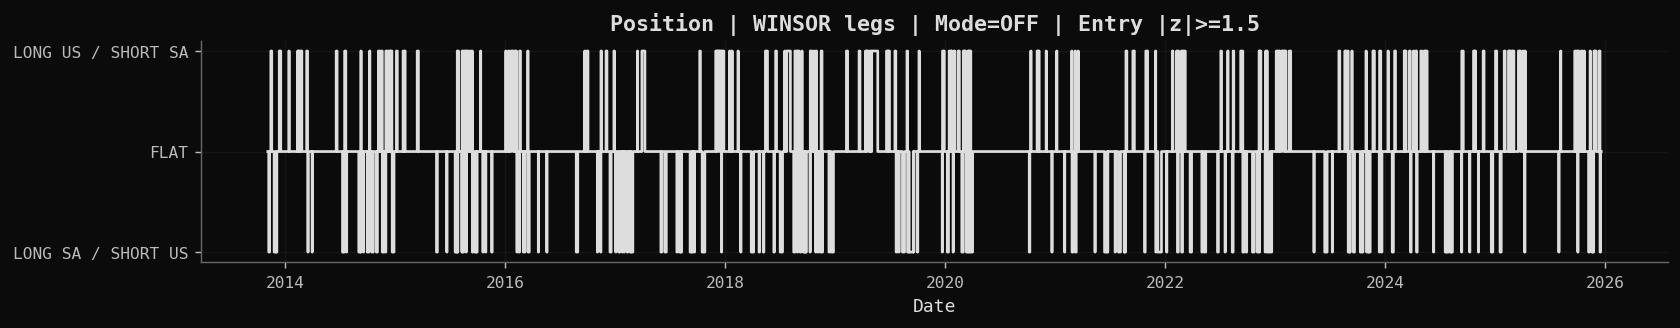

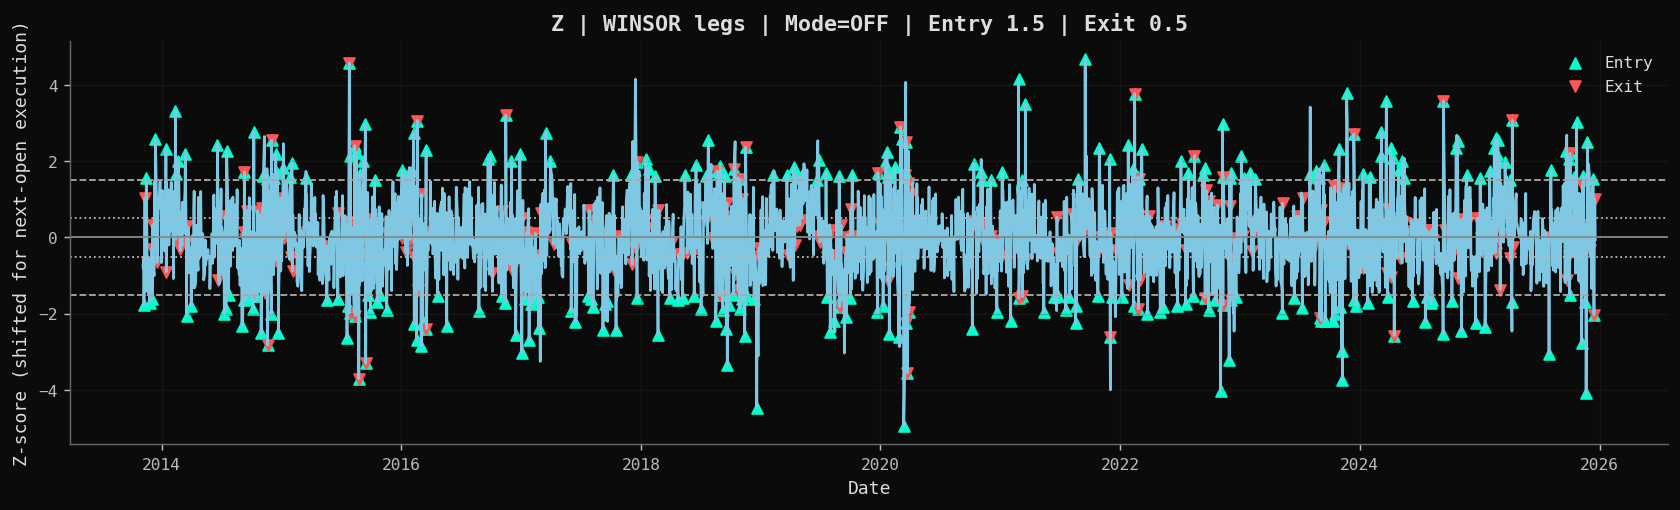

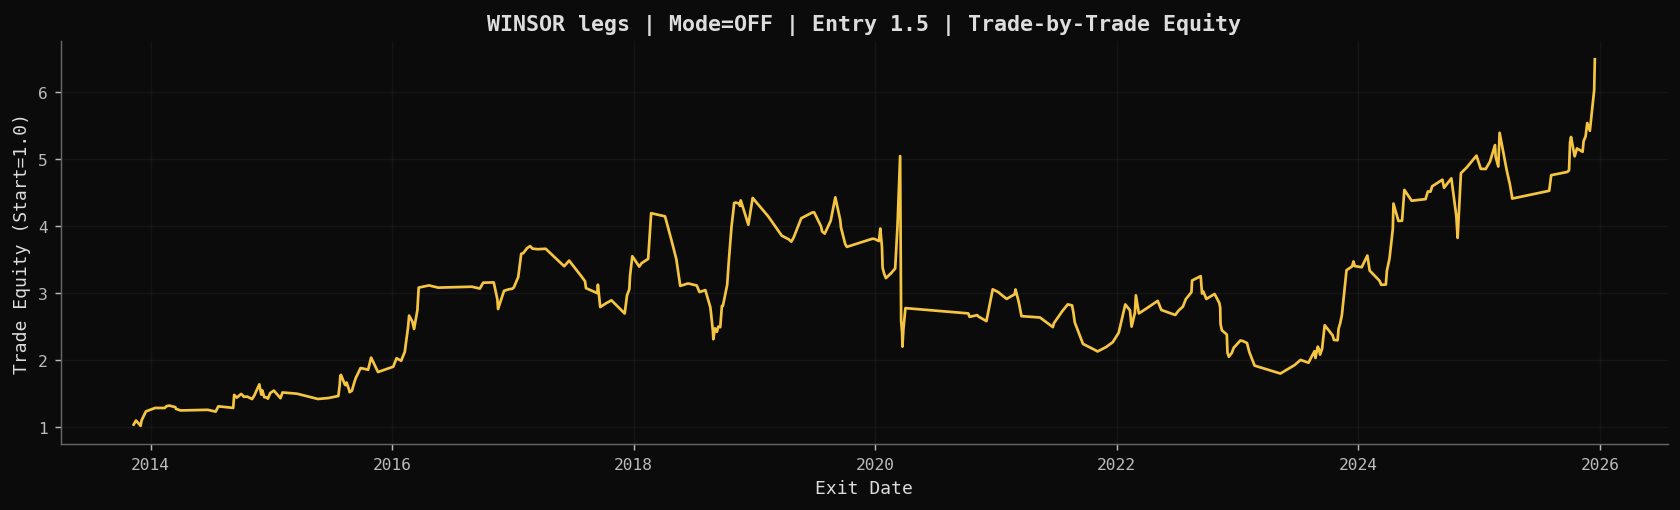

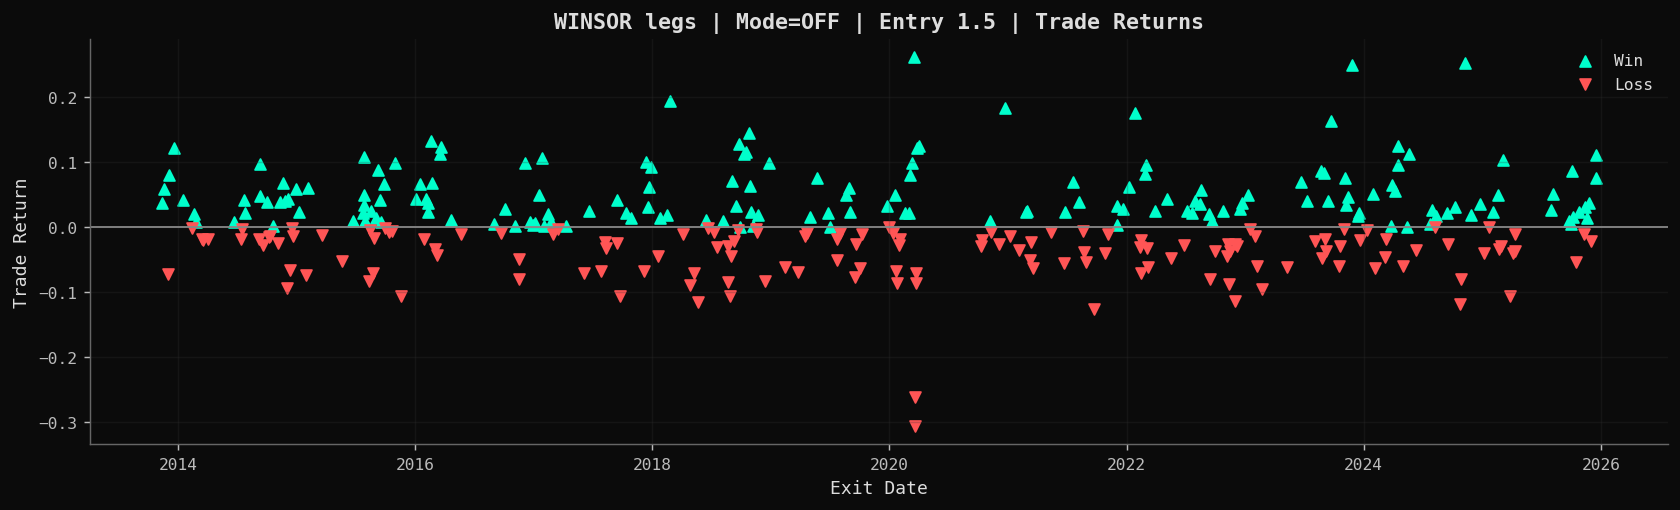

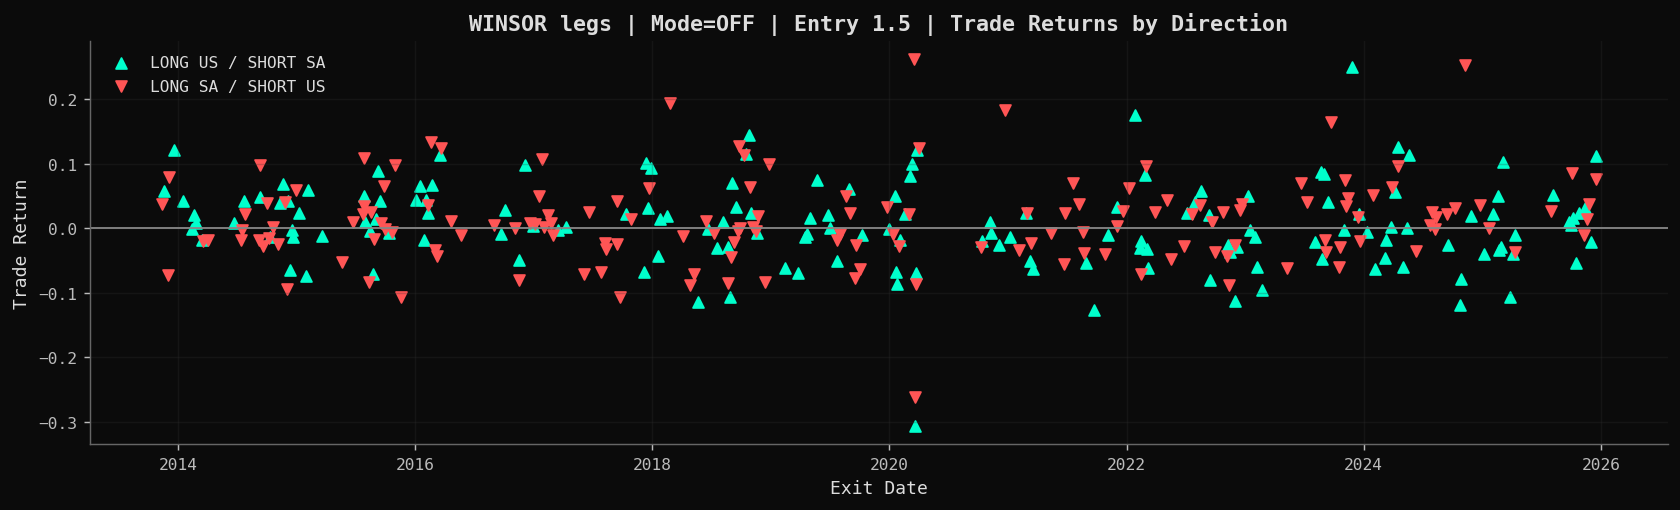

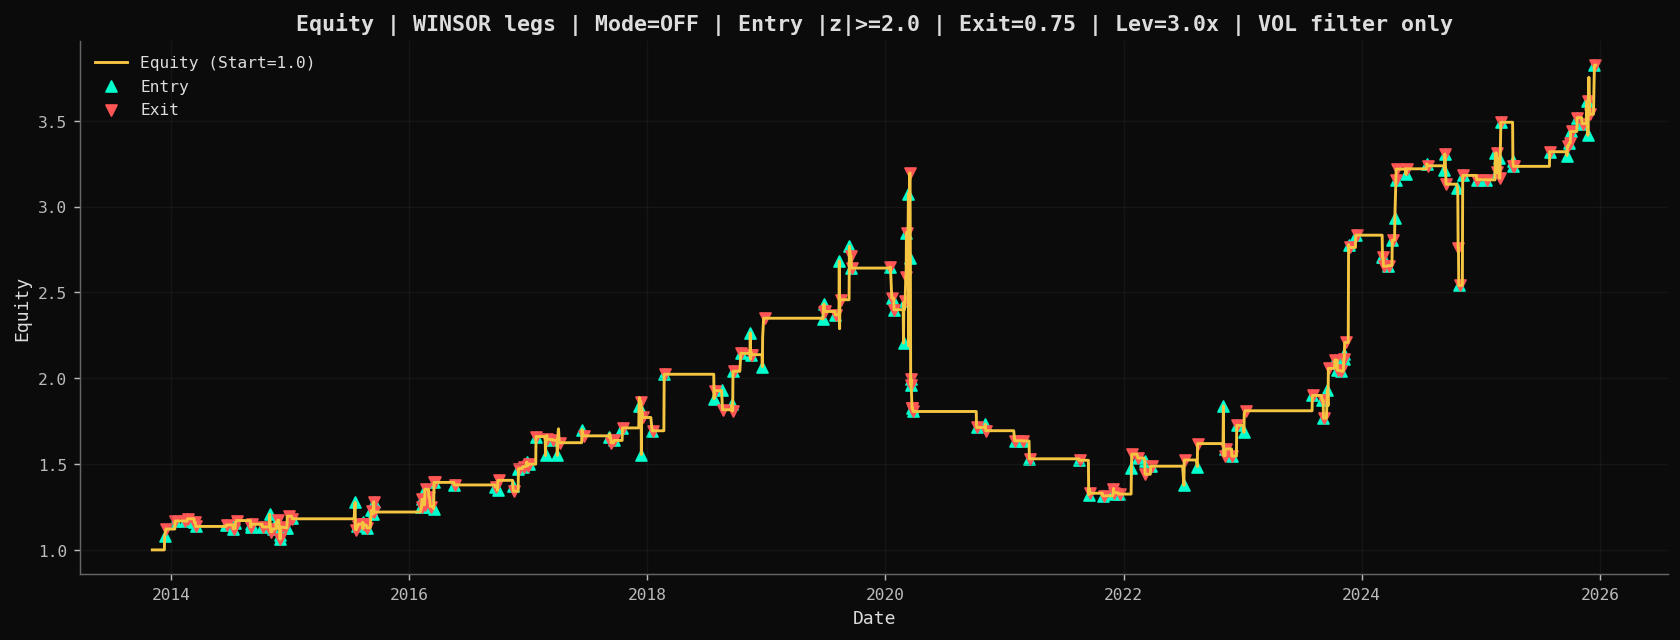

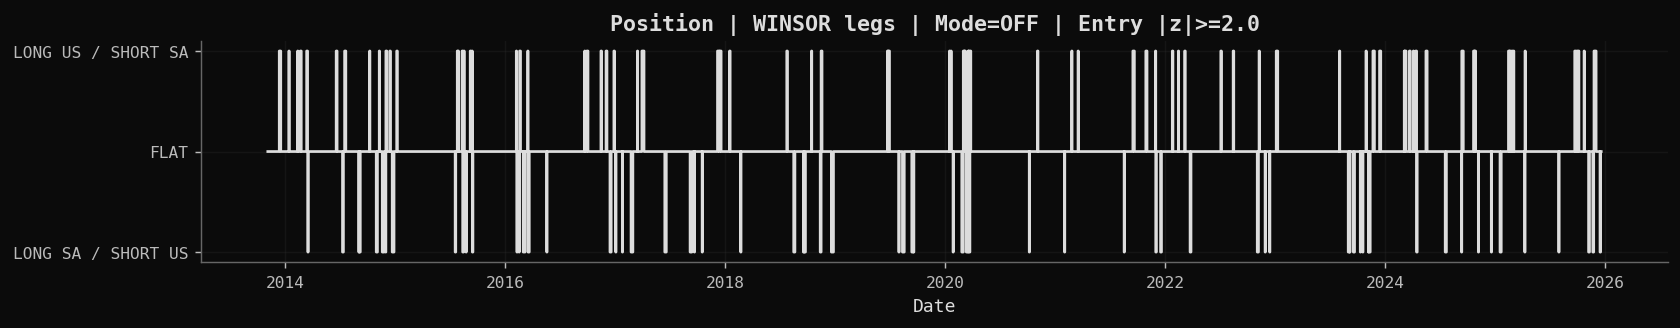

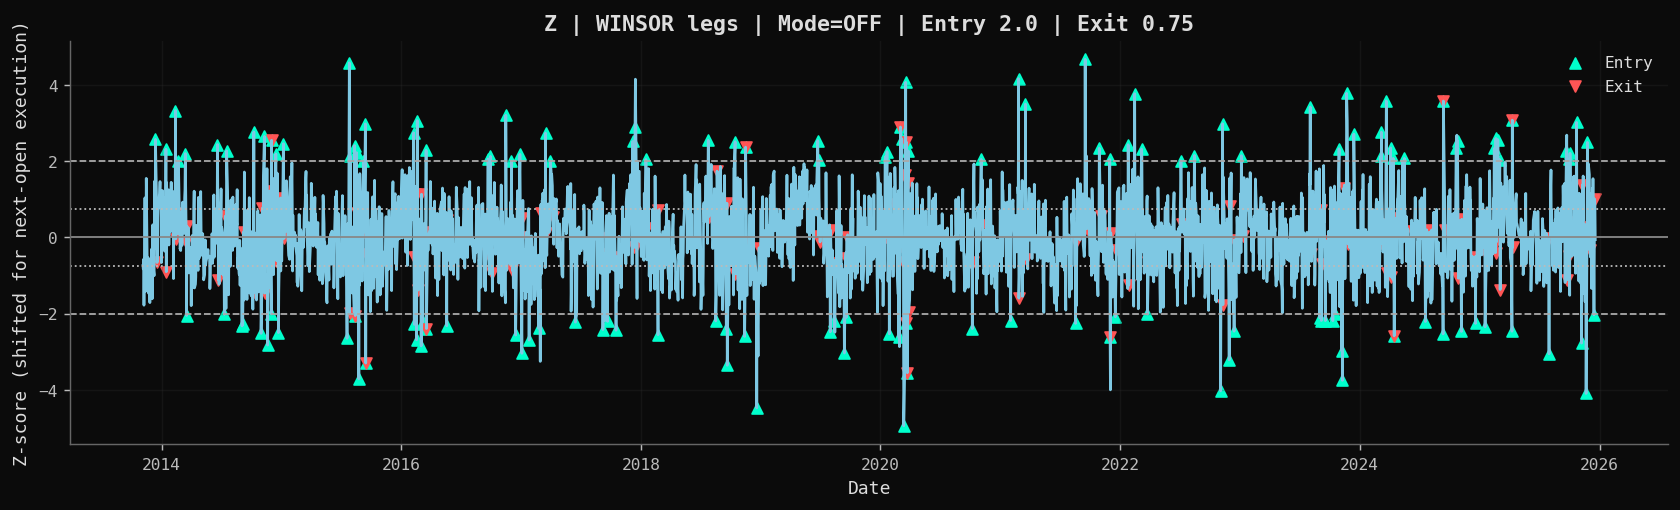

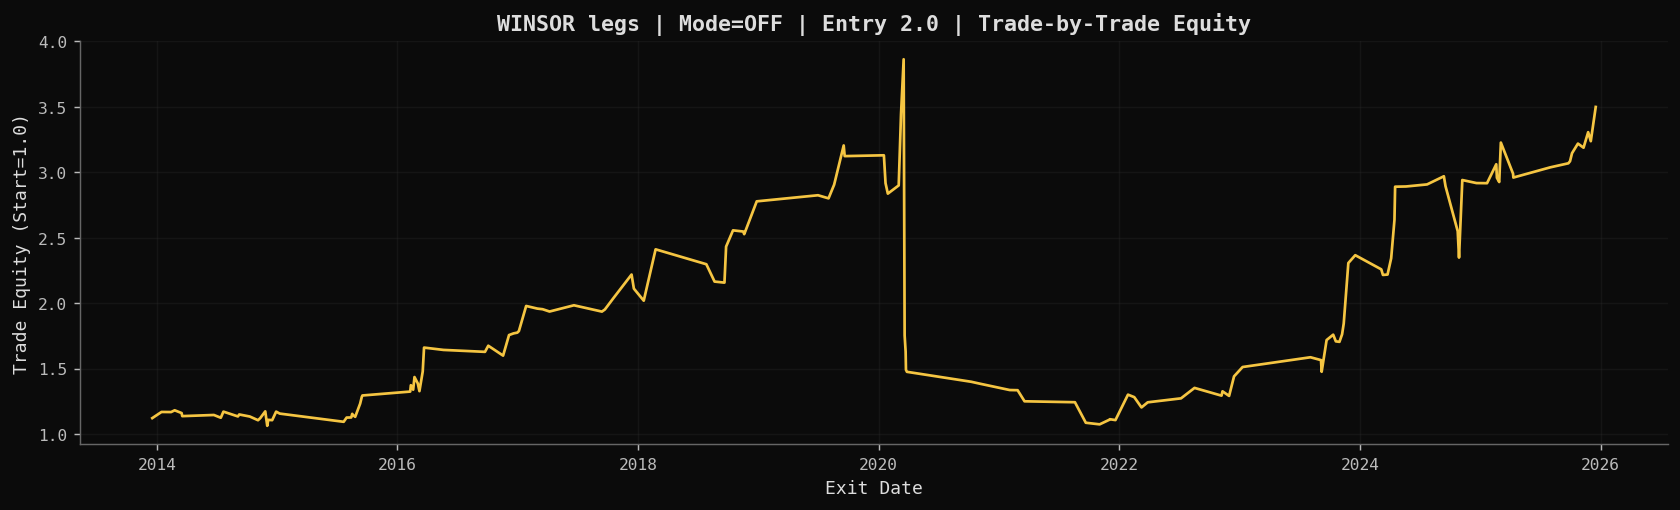

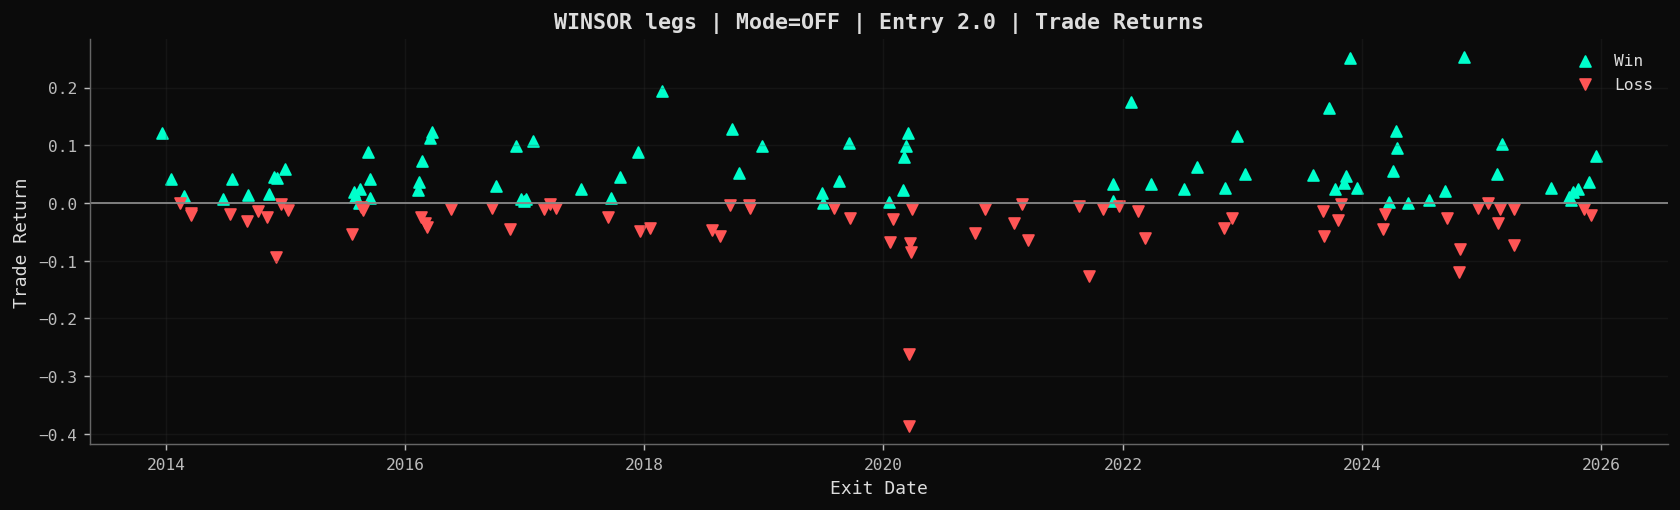

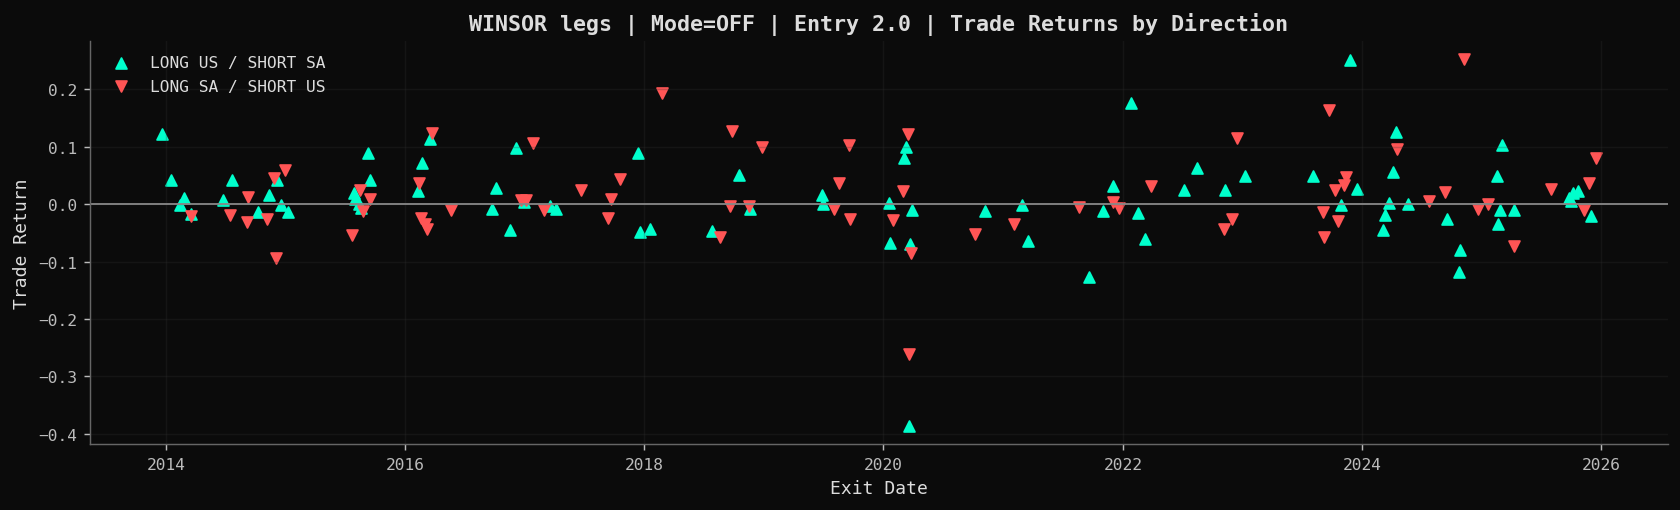

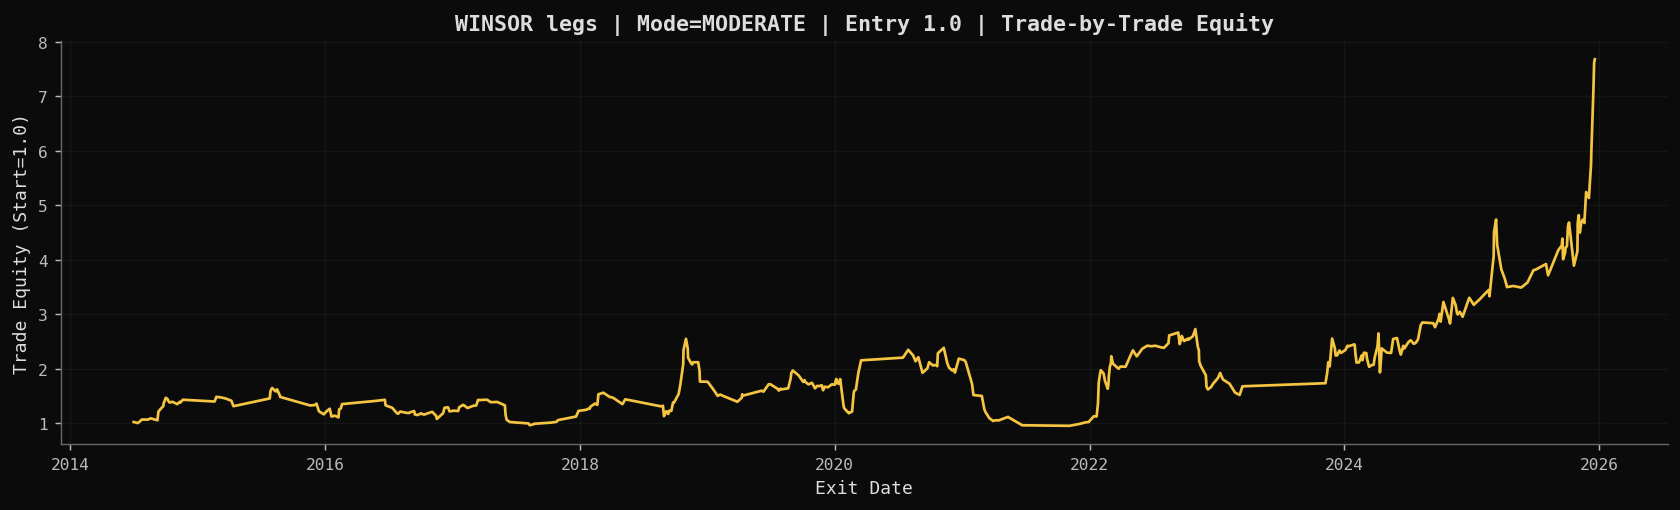

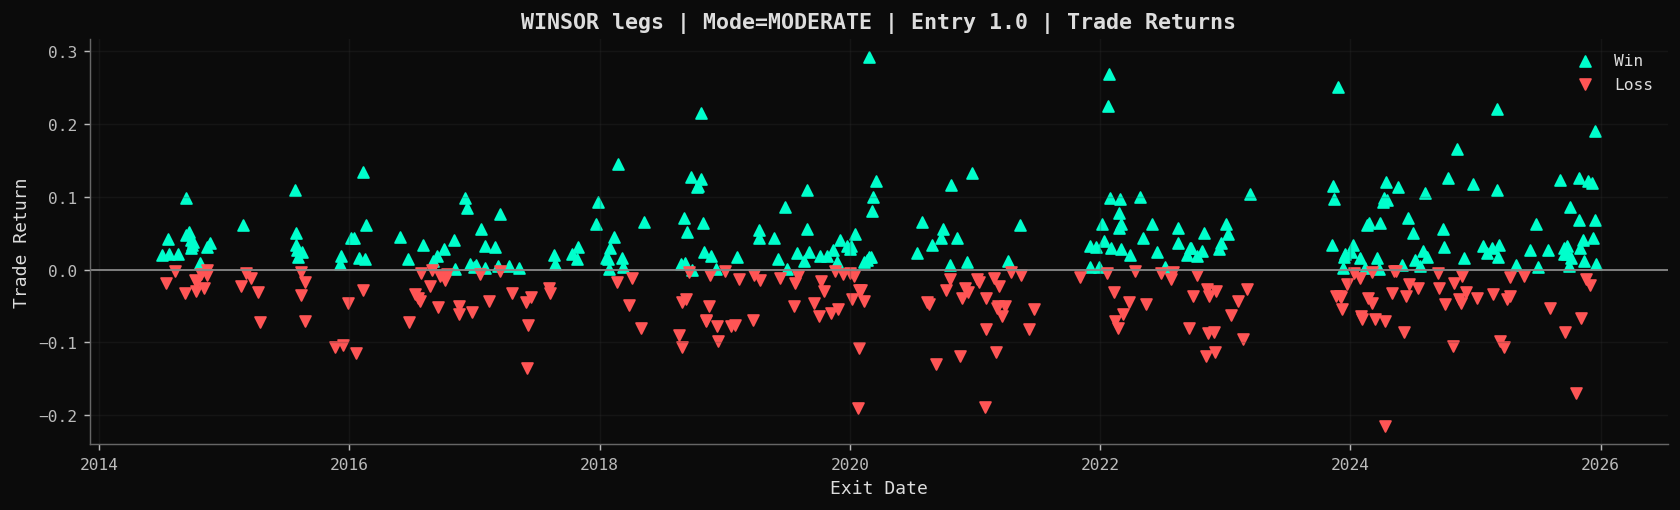

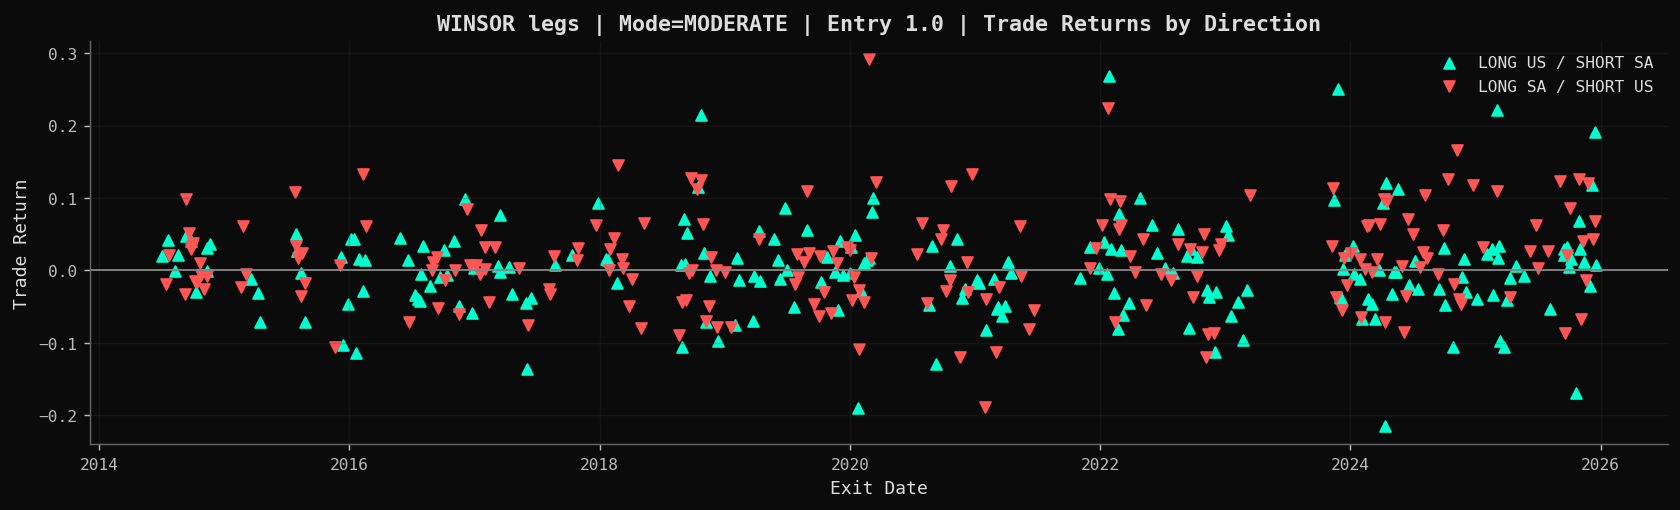

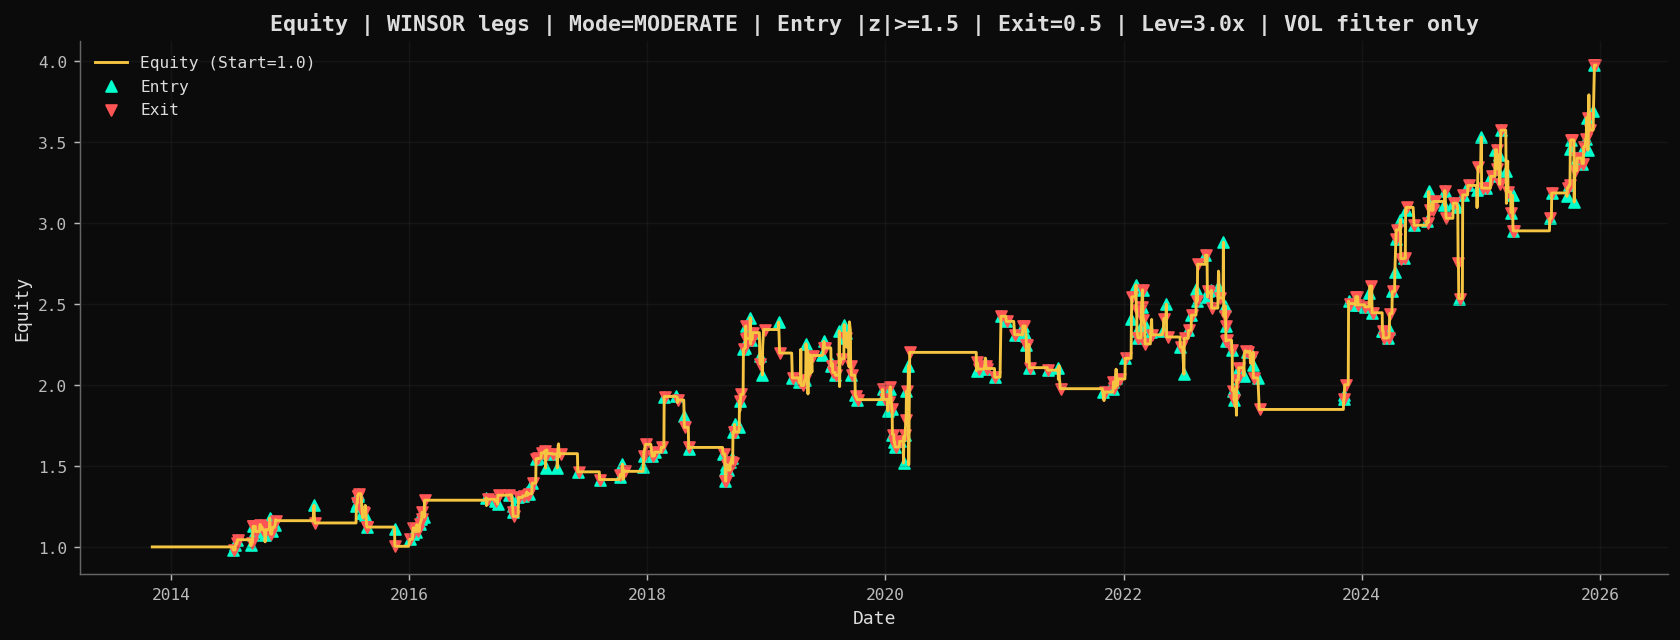

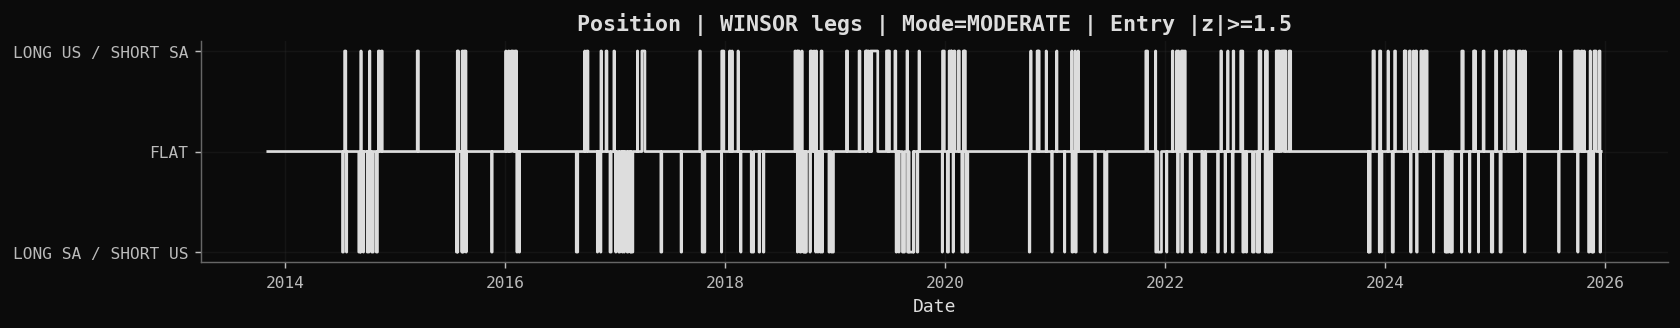

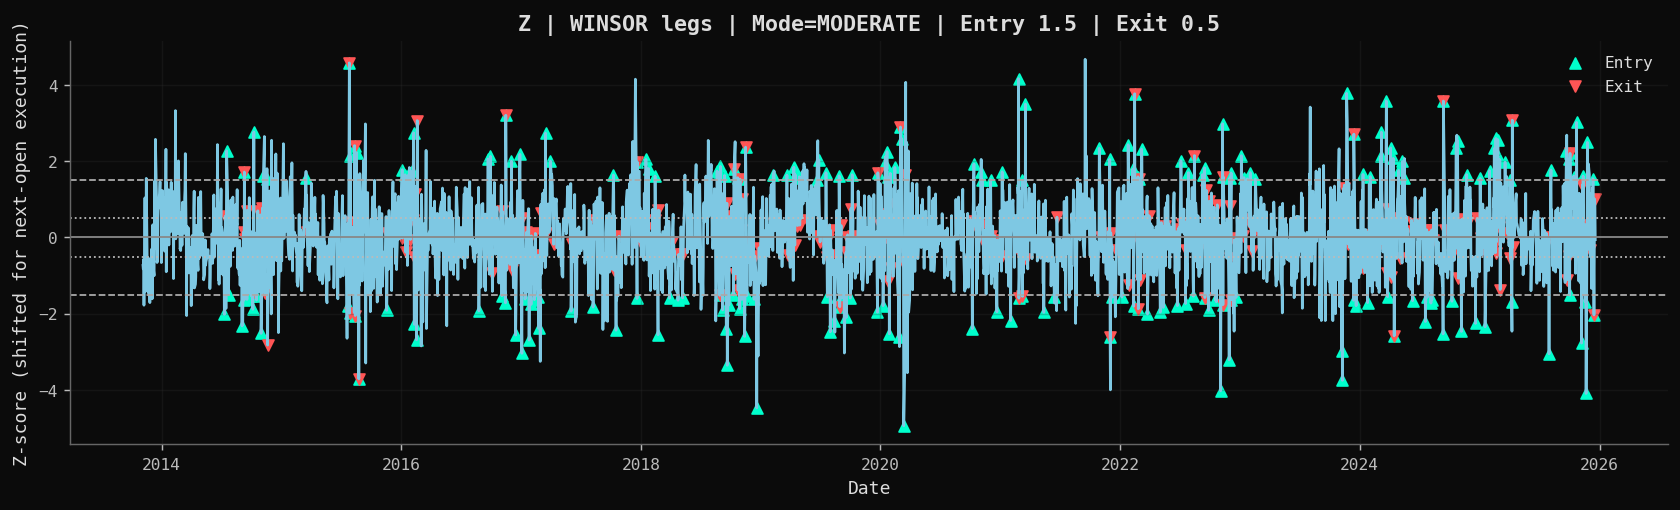

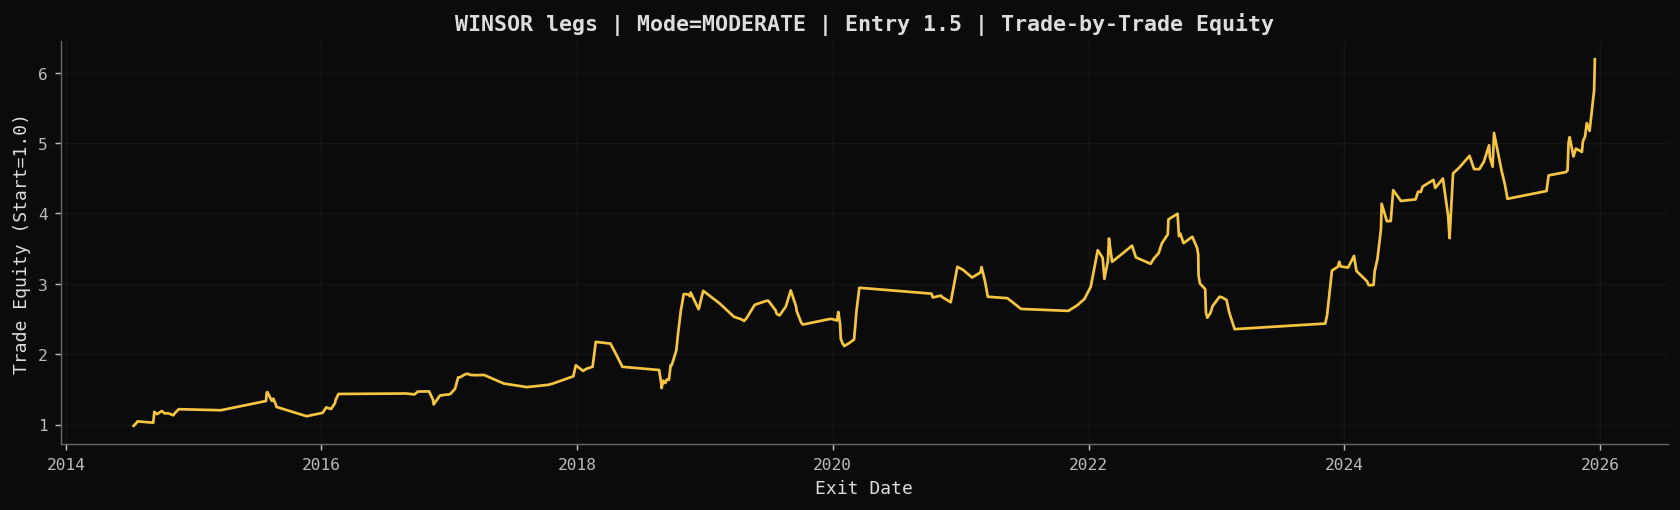

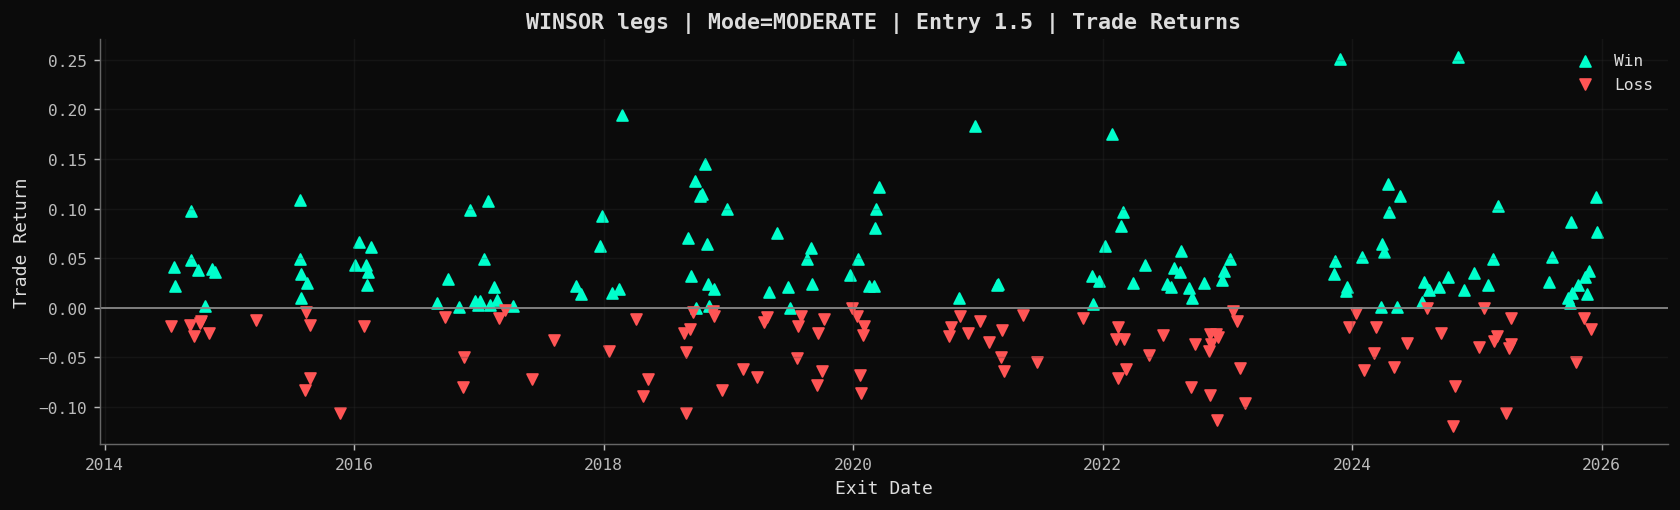

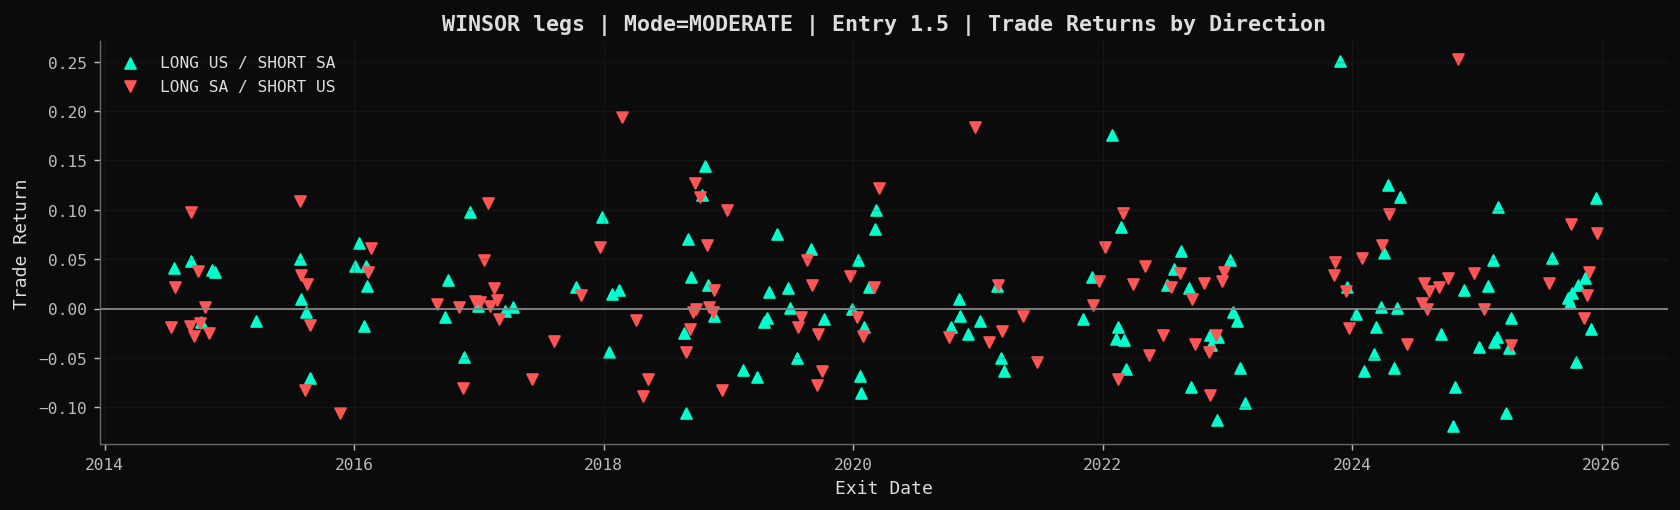

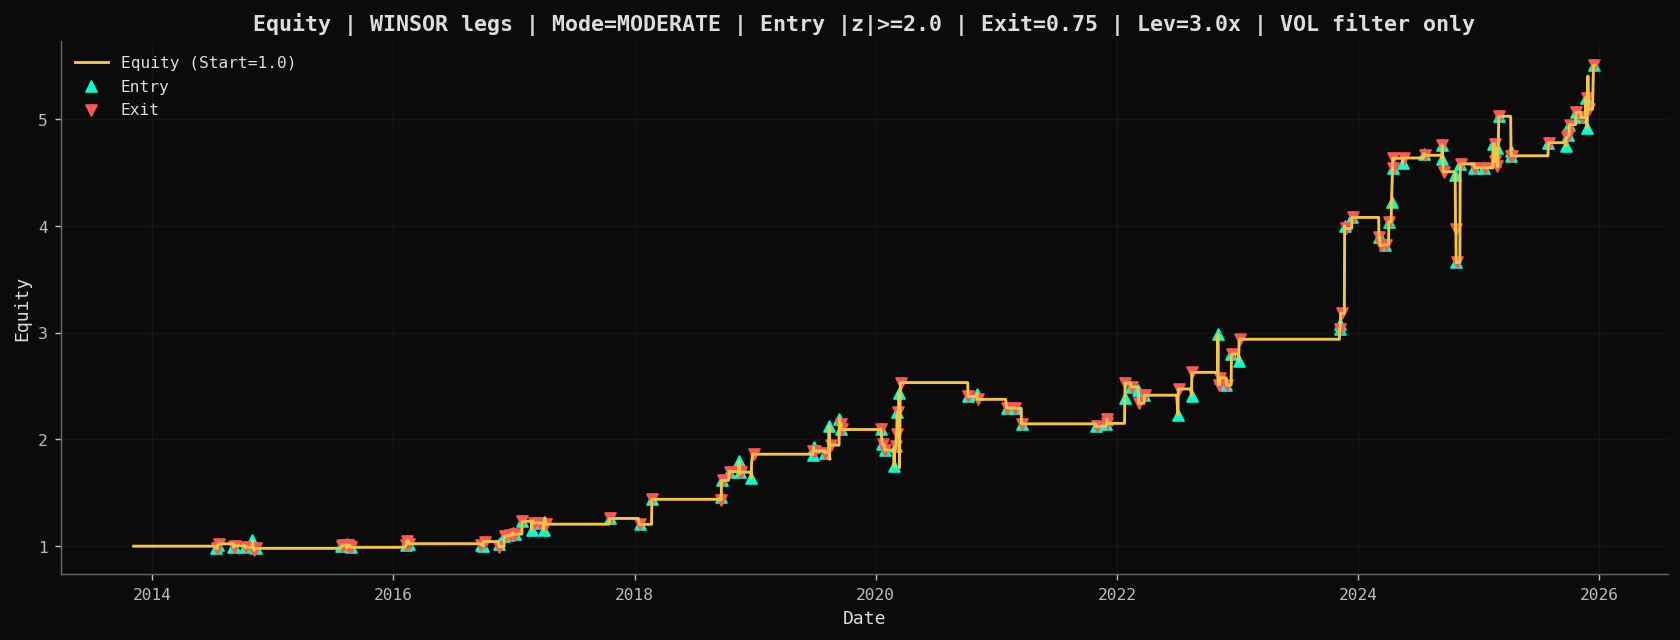

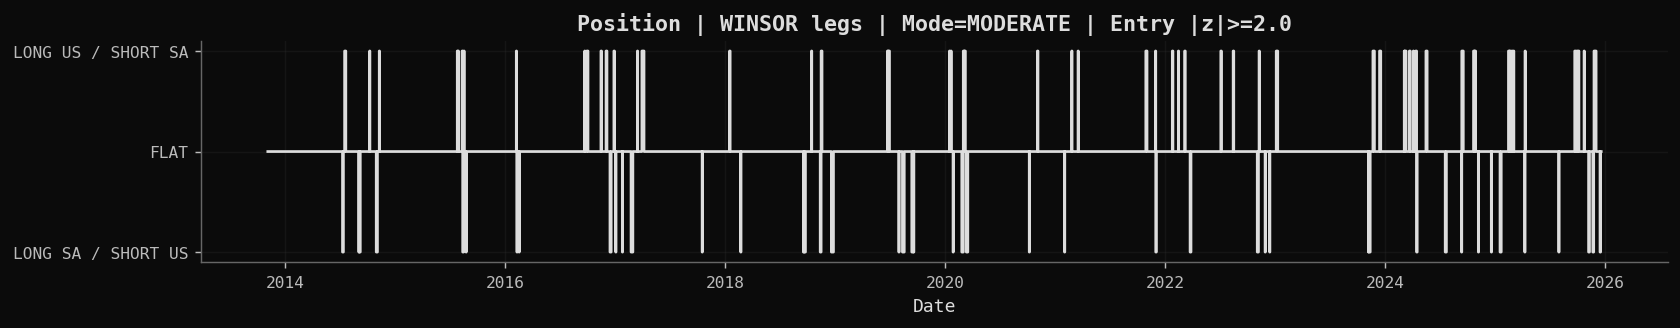

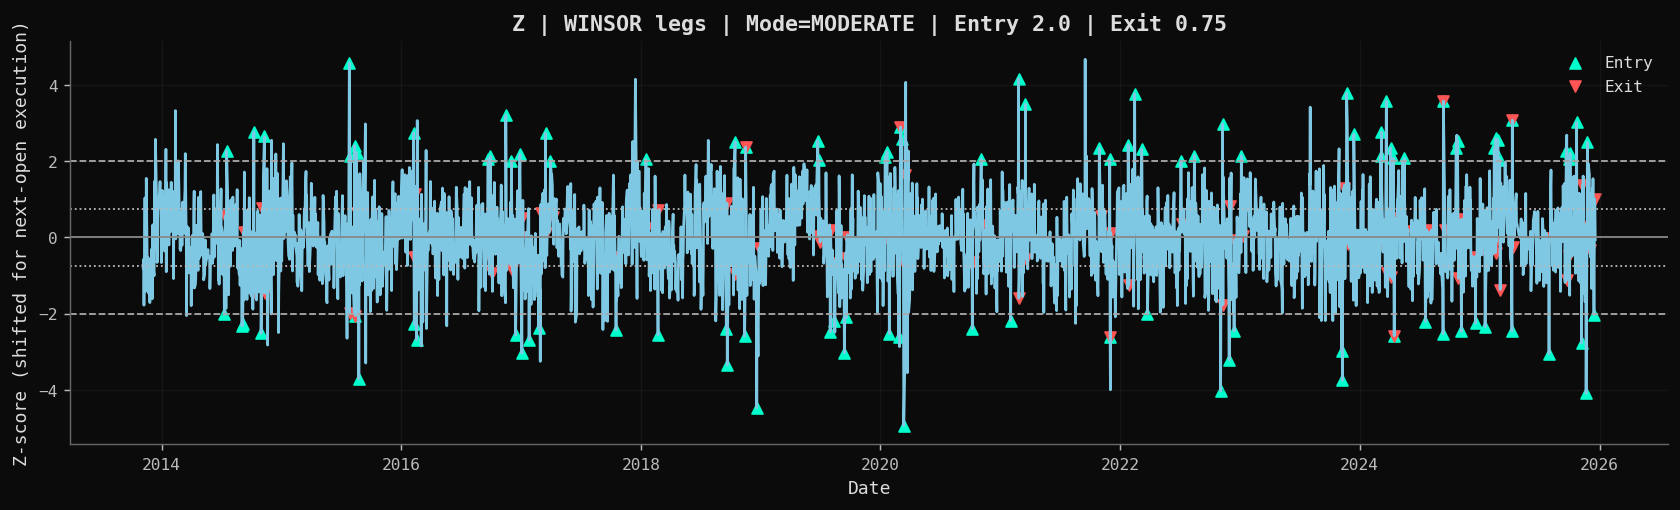

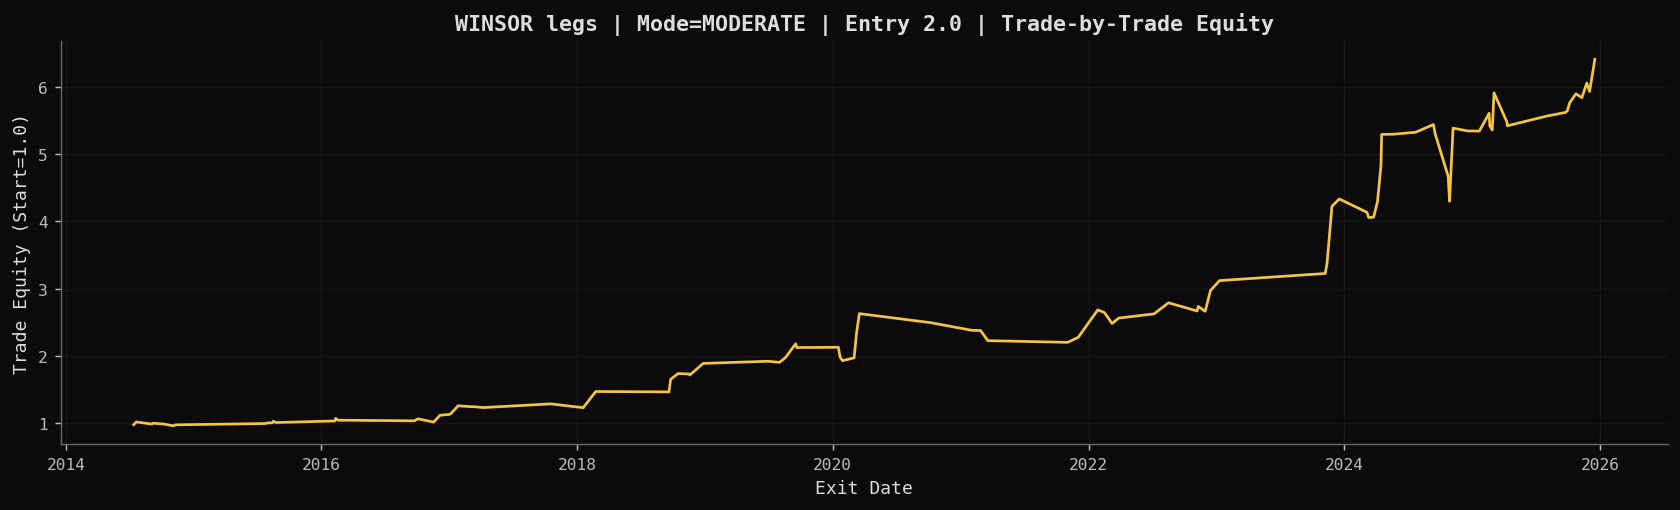

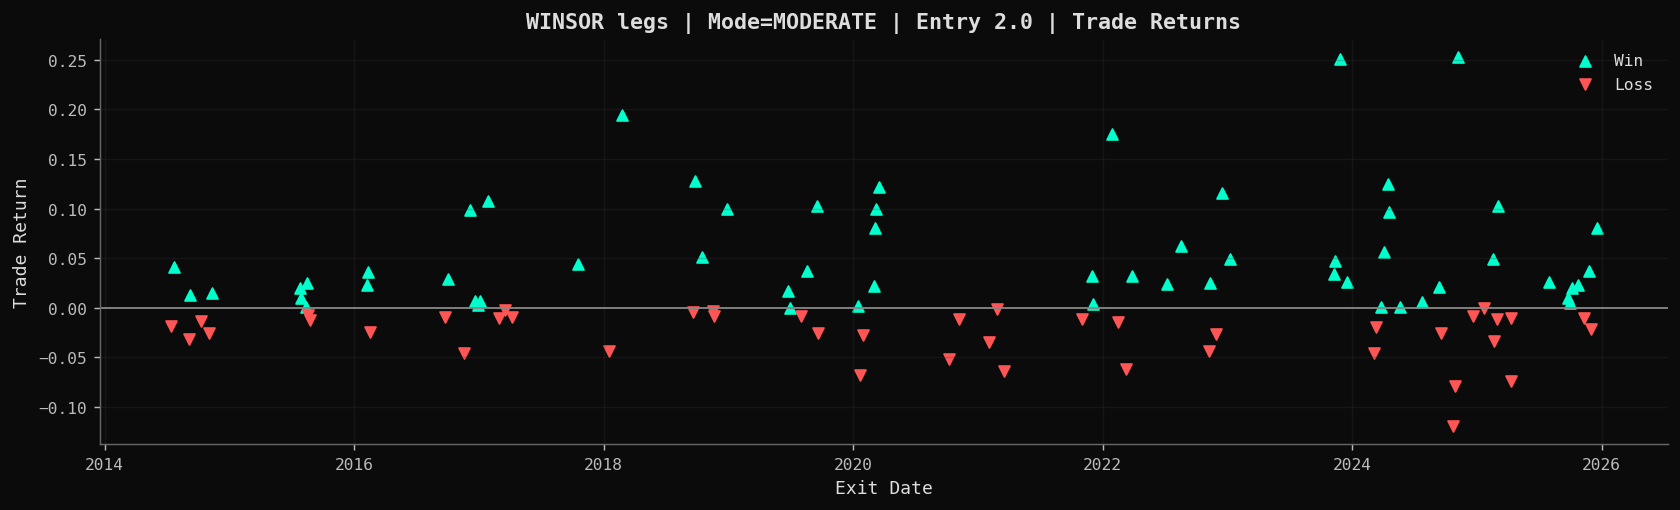

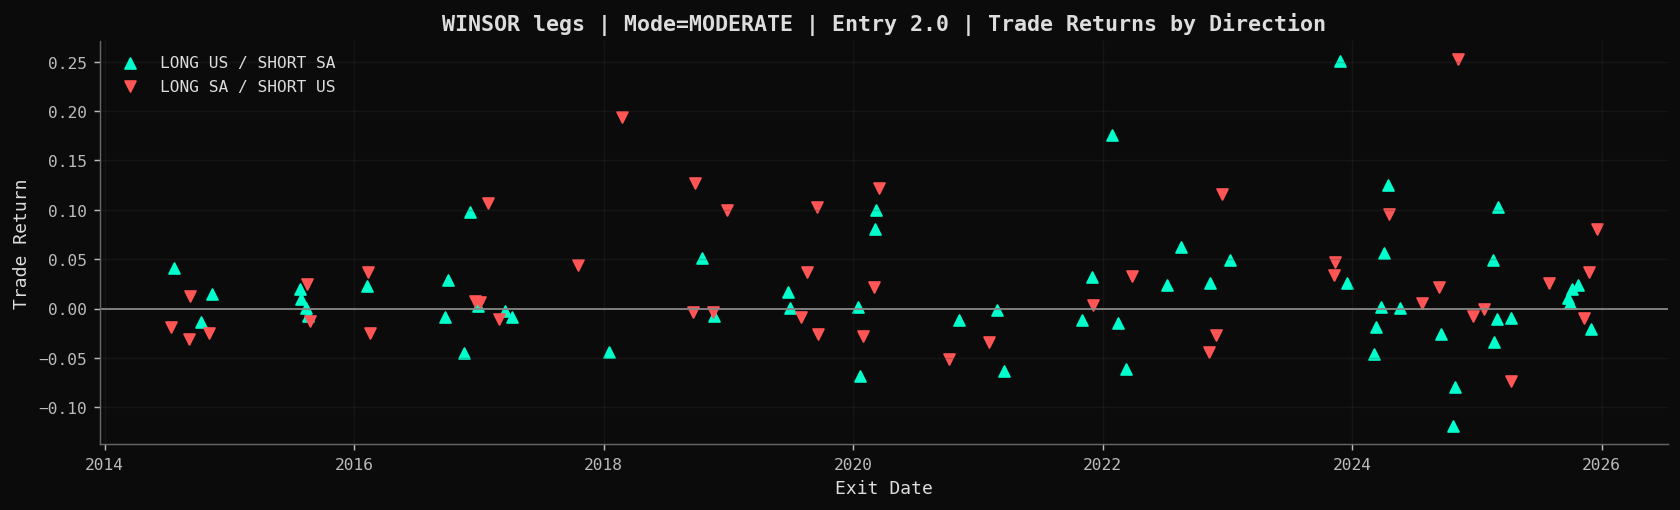


=== TRADE LOG (RAW legs | Mode=OFF | Entry |z| >= 1.0) | rows=591 ===
   entry_date  exit_date  days_held   direction_label   entry_z    exit_z  \
0  2013-11-08 2013-11-11          1  LONG_SA_SHORT_US -1.780596  1.042622   
1  2013-11-11 2013-11-12          1  LONG_US_SHORT_SA  1.042622 -0.211944   
2  2013-11-13 2013-11-15          2  LONG_SA_SHORT_US -1.413803  1.554711   
3  2013-11-15 2013-11-18          1  LONG_US_SHORT_SA  1.554711 -0.653948   
4  2013-11-20 2013-12-05         10  LONG_SA_SHORT_US -1.386835  0.334721   
5  2013-12-09 2013-12-10          1  LONG_SA_SHORT_US -1.005267  0.997673   
6  2013-12-11 2013-12-12          1  LONG_US_SHORT_SA  1.486586 -0.278324   
7  2013-12-13 2013-12-18          2  LONG_US_SHORT_SA  2.581141 -0.657242   
8  2013-12-27 2013-12-31          2  LONG_US_SHORT_SA  1.470439 -0.660396   
9  2014-01-03 2014-01-09          4  LONG_US_SHORT_SA  1.235381 -0.160069   
10 2014-01-14 2014-01-15          1  LONG_US_SHORT_SA  2.320440 -0.900443   
11 20

In [30]:
# ============================================================
# FULL FRESH WORKING COLAB SCRIPT (END-TO-END)
# Cross-Listing Stat Arb: SBSW (NYSE, USD) vs SSWJ (JSE, ZAR) + USDZAR FX
#
# YOUR REQUIRED CHANGES (NO FEATURES REMOVED):
# - KEEP volatility filter (ENTRY gate only)
# - DROP reversion hit-rate filter entirely
# - WINSOR: 95% LEVEL, UPSIDE-ONLY CAP
# - REMOVE cash sleeve (explicit instruction)
# - 3x leverage: MUST scale PnL, financing, and slippage consistently
# - KEEP: RAW vs WINSOR diagnostics + side-by-side metrics
# - KEEP: charts, trade logs, SPX correlation + alpha/beta regression vs SPX (open->open)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# MATPLOTLIB STYLE (BLOOMBERG-ISH)
# -------------------------
plt.rcParams.update({
    "figure.dpi": 130,
    "figure.facecolor": "#0b0b0b",
    "axes.facecolor": "#0b0b0b",
    "axes.edgecolor": "#666666",
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.color": "#333333",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.color": "#bbbbbb",
    "ytick.color": "#bbbbbb",
    "axes.labelcolor": "#dddddd",
    "text.color": "#dddddd",
    "legend.frameon": False,
    "font.family": "DejaVu Sans Mono",
})

# -------------------------
# USER CONFIG
# -------------------------
PATH_US = "SBSW Historical Data (2).csv"          # NYSE listing (USD)
PATH_SA = "SSWJ Historical Data (2).csv"          # JSE listing (ZAR)
PATH_FX = "USD_ZAR Historical Data (2).csv"       # USDZAR (ZAR per USD)
PATH_SP = "S&P 500 Historical Data (8).csv"       # S&P 500 (USD)

ENTRY_Z_LIST = [1.0, 1.5, 2.0]
EXIT_BUFFER_MAP = {1.0: 0.25, 1.5: 0.50, 2.0: 0.75}

ROLL_WINDOW = 90  # for hedge ratio + spread z-score (close-based)
TRADING_DAYS_PER_YEAR = 252

FIN_SA = 0.13
FIN_US = 0.07

ROUND_TRIP_TOTAL_BPS = 60.0
BPS_PER_LEG_PER_EVENT = ROUND_TRIP_TOTAL_BPS / 4.0
SLIP_PER_LEG_PER_EVENT = BPS_PER_LEG_PER_EVENT / 10000.0

# -------------------------
# WINSOR (UPDATED PER INSTRUCTION)
# -------------------------
WINSOR_LEVEL = 0.95
WINSOR_UPSIDE_ONLY = True

MAX_HOLD_DAYS = None

# -------------------------
# LEVERAGE CONFIG
# -------------------------
LEVERAGE = 3.0  # exposure leverage: MUST scale PnL, financing, slippage consistently

# -------------------------
# VOL FILTER CONFIG (KEEP)
# -------------------------
VOL_WIN = 60
VOL_PCTL_LOW, VOL_PCTL_HIGH = 0.10, 0.90

# -------------------------
# HELPERS
# -------------------------
def clean_investing_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

    for col in ["Price", "Open", "High", "Low"]:
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                .str.replace(",", "", regex=False)
                .str.replace("%", "", regex=False)
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def sanity_check_cols(df: pd.DataFrame, name: str):
    need = {"Date", "Open", "Price"}
    if not need.issubset(df.columns):
        raise ValueError(f"{name} missing columns. Need {need}, found {set(df.columns)}")

def winsor_clip_bounds(s: pd.Series, level: float = 0.95, upside_only: bool = True):
    s2 = s.dropna()
    if len(s2) == 0:
        return (np.nan, np.nan)

    if upside_only:
        lo = -np.inf
        hi = float(s2.quantile(level))
        return (lo, hi)

    tail = (1.0 - level) / 2.0
    lo = float(s2.quantile(tail))
    hi = float(s2.quantile(1.0 - tail))
    return (lo, hi)

def winsorize_series(s: pd.Series, level: float = 0.95, upside_only: bool = True) -> pd.Series:
    s = s.copy()
    lo, hi = winsor_clip_bounds(s, level=level, upside_only=upside_only)
    return s.clip(lower=lo, upper=hi)

def winsor_diagnostics(s: pd.Series, level: float = 0.95, name: str = "", upside_only: bool = True) -> dict:
    s2 = s.dropna()
    if len(s2) == 0:
        return {
            "name": name, "n": 0,
            "lo": np.nan, "hi": np.nan,
            "n_lo_clip": 0, "n_hi_clip": 0,
            "p01": np.nan, "p025": np.nan, "p05": np.nan,
            "p50": np.nan,
            "p95": np.nan, "p975": np.nan, "p99": np.nan
        }

    lo, hi = winsor_clip_bounds(s2, level=level, upside_only=upside_only)
    n_lo = int((s2 < lo).sum()) if np.isfinite(lo) else 0
    n_hi = int((s2 > hi).sum()) if np.isfinite(hi) else 0

    return {
        "name": name,
        "n": int(len(s2)),
        "lo": float(lo) if np.isfinite(lo) else -np.inf,
        "hi": float(hi) if np.isfinite(hi) else np.inf,
        "n_lo_clip": n_lo,
        "n_hi_clip": n_hi,
        "p01": float(s2.quantile(0.01)),
        "p025": float(s2.quantile(0.025)),
        "p05": float(s2.quantile(0.05)),
        "p50": float(s2.quantile(0.50)),
        "p95": float(s2.quantile(0.95)),
        "p975": float(s2.quantile(0.975)),
        "p99": float(s2.quantile(0.99)),
    }

def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = equity / peak - 1.0
    return float(dd.min()) if len(dd) else np.nan

def cagr(equity: pd.Series, freq: int = TRADING_DAYS_PER_YEAR) -> float:
    equity = equity.dropna()
    if len(equity) < 2:
        return np.nan
    years = (len(equity) - 1) / freq
    if years <= 0:
        return np.nan
    return float(equity.iloc[-1] ** (1 / years) - 1)

def ann_vol(daily_ret: pd.Series) -> float:
    daily_ret = daily_ret.dropna()
    if len(daily_ret) < 10:
        return np.nan
    return float(daily_ret.std(ddof=0) * np.sqrt(TRADING_DAYS_PER_YEAR))

def sharpe_rf(daily_ret: pd.Series, rf_annual: float = 0.0) -> float:
    daily_ret = daily_ret.dropna()
    if len(daily_ret) < 10:
        return np.nan
    rf_daily = rf_annual / TRADING_DAYS_PER_YEAR
    excess = daily_ret - rf_daily
    vol = excess.std(ddof=0)
    if vol == 0:
        return np.nan
    return float(np.sqrt(TRADING_DAYS_PER_YEAR) * excess.mean() / vol)

def regression_alpha_beta(y: pd.Series, x: pd.Series):
    df_ = pd.concat([y, x], axis=1).dropna()
    if len(df_) < 20:
        return (np.nan, np.nan, np.nan)

    yv = df_.iloc[:, 0].values
    xv = df_.iloc[:, 1].values

    vx = np.var(xv, ddof=0)
    if vx == 0:
        return (np.nan, np.nan, np.nan)

    cov = np.mean((xv - xv.mean()) * (yv - yv.mean()))
    beta_ = cov / vx
    alpha_ = yv.mean() - beta_ * xv.mean()

    yhat = alpha_ + beta_ * xv
    ss_res = np.sum((yv - yhat) ** 2)
    ss_tot = np.sum((yv - yv.mean()) ** 2)
    r2 = np.nan if ss_tot == 0 else (1.0 - ss_res / ss_tot)

    return (float(alpha_), float(beta_), float(r2))

def build_trade_log(d: pd.DataFrame) -> pd.DataFrame:
    entries = d.index[d["entry"]].tolist()
    exits   = d.index[d["exit"]].tolist()

    log = []
    j = 0
    for i in entries:
        while j < len(exits) and exits[j] <= i:
            j += 1
        if j >= len(exits):
            break
        k = exits[j]
        seg = d.loc[i:k].copy()

        trade_ret = float((1.0 + seg["ret"]).prod() - 1.0)

        direction = int(d.loc[i, "pos"])
        log.append({
            "entry_date": d.loc[i, "Date"],
            "exit_date": d.loc[k, "Date"],
            "days_held": int(k - i),
            "direction": direction,
            "direction_label": "LONG_US_SHORT_SA" if direction == 1 else "LONG_SA_SHORT_US",
            "entry_z": float(d.loc[i, "z_for_position"]),
            "exit_z": float(d.loc[k, "z_for_position"]),
            "trade_return": trade_ret,
            "win": trade_ret > 0
        })
        j += 1

    return pd.DataFrame(log)

# -------------------------
# VOL FILTER IMPLEMENTATION (KEPT)
# -------------------------
def compute_spread_vol_gate(resid: pd.Series) -> pd.Series:
    sv = resid.diff().rolling(VOL_WIN).std(ddof=0)
    p_lo = sv.expanding(min_periods=max(VOL_WIN, ROLL_WINDOW)).quantile(VOL_PCTL_LOW)
    p_hi = sv.expanding(min_periods=max(VOL_WIN, ROLL_WINDOW)).quantile(VOL_PCTL_HIGH)
    gate = (sv >= p_lo) & (sv <= p_hi)
    gate = gate.fillna(True)
    return gate

# -------------------------
# LOAD + MERGE
# -------------------------
sa = clean_investing_csv(PATH_SA)
us = clean_investing_csv(PATH_US)
fx = clean_investing_csv(PATH_FX)
sp = clean_investing_csv(PATH_SP)

sanity_check_cols(sa, "SSWJ (SA)")
sanity_check_cols(us, "SBSW (US)")
sanity_check_cols(fx, "USDZAR (FX)")
sanity_check_cols(sp, "S&P 500 (SPX)")

print("=== RAW FILE DATE RANGES ===")
print("SSWJ:", sa["Date"].min().date(), "->", sa["Date"].max().date(), "rows", len(sa))
print("SBSW:", us["Date"].min().date(), "->", us["Date"].max().date(), "rows", len(us))
print("USDZAR:", fx["Date"].min().date(), "->", fx["Date"].max().date(), "rows", len(fx))
print("SPX :", sp["Date"].min().date(), "->", sp["Date"].max().date(), "rows", len(sp))

sa = sa[["Date", "Open", "Price"]].rename(columns={"Open":"SA_Open_ZAR", "Price":"SA_Close_ZAR"})
us = us[["Date", "Open", "Price"]].rename(columns={"Open":"US_Open_USD", "Price":"US_Close_USD"})
fx = fx[["Date", "Open", "Price"]].rename(columns={"Open":"FX_Open", "Price":"FX_Close"})
sp = sp[["Date", "Open", "Price"]].rename(columns={"Open":"SP_Open", "Price":"SP_Close"})

df = sa.merge(us, on="Date", how="inner").merge(fx, on="Date", how="inner").sort_values("Date").reset_index(drop=True)

print("\n=== INNER-JOINED DATE RANGE (SSWJ+SBSW+USDZAR overlap) ===")
print("Start:", df["Date"].min().date(), "End:", df["Date"].max().date(), "rows", len(df))

# -------------------------
# FX ADJUST + RETURNS
# -------------------------
df["SA_Open_USD"]  = df["SA_Open_ZAR"]  / df["FX_Open"]
df["SA_Close_USD"] = df["SA_Close_ZAR"] / df["FX_Close"]

df = df[(df["SA_Open_USD"] > 0) & (df["SA_Close_USD"] > 0) & (df["US_Open_USD"] > 0) & (df["US_Close_USD"] > 0)].copy()
df = df.reset_index(drop=True)

# Execution returns: OPEN->OPEN
df["SA_ret_oo_raw"] = df["SA_Open_USD"].pct_change()
df["US_ret_oo_raw"] = df["US_Open_USD"].pct_change()

df["SA_ret_oo_win"] = winsorize_series(df["SA_ret_oo_raw"], level=WINSOR_LEVEL, upside_only=WINSOR_UPSIDE_ONLY)
df["US_ret_oo_win"] = winsorize_series(df["US_ret_oo_raw"], level=WINSOR_LEVEL, upside_only=WINSOR_UPSIDE_ONLY)

leg_diag = pd.DataFrame([
    winsor_diagnostics(df["SA_ret_oo_raw"], level=WINSOR_LEVEL, name="SA_ret_oo_raw", upside_only=WINSOR_UPSIDE_ONLY),
    winsor_diagnostics(df["SA_ret_oo_win"], level=WINSOR_LEVEL, name="SA_ret_oo_win", upside_only=WINSOR_UPSIDE_ONLY),
    winsor_diagnostics(df["US_ret_oo_raw"], level=WINSOR_LEVEL, name="US_ret_oo_raw", upside_only=WINSOR_UPSIDE_ONLY),
    winsor_diagnostics(df["US_ret_oo_win"], level=WINSOR_LEVEL, name="US_ret_oo_win", upside_only=WINSOR_UPSIDE_ONLY),
])
print("\n=== WINSOR DIAGNOSTICS (LEG RETURNS) ===")
print(f"Winsor rule: level={WINSOR_LEVEL:.2f}, upside_only={WINSOR_UPSIDE_ONLY} (cap at {int(WINSOR_LEVEL*100)}th percentile only)")
print(leg_diag)

# -------------------------
# SPREAD MODEL (CLOSES) + ZSCORE
# -------------------------
df["x"] = np.log(df["SA_Close_USD"])
df["y"] = np.log(df["US_Close_USD"])

roll = ROLL_WINDOW
cov_xy = df["x"].rolling(roll).cov(df["y"])
var_x  = df["x"].rolling(roll).var()
df["beta"]  = cov_xy / var_x
df["alpha"] = df["y"].rolling(roll).mean() - df["beta"] * df["x"].rolling(roll).mean()
df["resid"] = df["y"] - (df["alpha"] + df["beta"] * df["x"])

mu = df["resid"].rolling(roll).mean()
sd = df["resid"].rolling(roll).std(ddof=0)
df["z"] = (df["resid"] - mu) / sd

# Signal at close(t) -> decision for open(t+1)
df["z_for_position"] = df["z"].shift(1)
df["beta_for_position"] = df["beta"].shift(1)

# -------------------------
# BACKTEST WINDOW
# -------------------------
need_cols = [
    "z_for_position","beta_for_position",
    "SA_ret_oo_raw","US_ret_oo_raw","SA_ret_oo_win","US_ret_oo_win",
    "resid"
]
df_bt = df.dropna(subset=need_cols).copy().reset_index(drop=True)

print("\n=== BACKTEST WINDOW (after rolling burn-in) ===")
print("Start:", df_bt["Date"].iloc[0].date(), "End:", df_bt["Date"].iloc[-1].date(), "rows", len(df_bt))
print("Costs: 60bps round-trip total =>", f"{BPS_PER_LEG_PER_EVENT:.2f}bps per leg per event",
      f"(= {SLIP_PER_LEG_PER_EVENT:.6f} decimal)")
print("Winsor:", f"{WINSOR_LEVEL*100:.0f}% level | upside_only={WINSOR_UPSIDE_ONLY}")
print("Entries:", ENTRY_Z_LIST, "Exit buffers:", EXIT_BUFFER_MAP)
print("LEVERAGE:", LEVERAGE, "(applied consistently to PnL + financing + slippage)")
print("VOL FILTER:", f"ON | VOL_WIN={VOL_WIN} | pctl [{VOL_PCTL_LOW:.2f},{VOL_PCTL_HIGH:.2f}]")

# -------------------------
# ADD SPX OPEN->OPEN RETURNS (benchmark alignment)
# -------------------------
sp = sp.sort_values("Date").reset_index(drop=True)
sp["SP_ret_oo"] = sp["SP_Open"].pct_change()
df_bt = df_bt.merge(sp[["Date","SP_Open","SP_Close","SP_ret_oo"]], on="Date", how="left")

# -------------------------
# BUILD VOL GATE ONLY (reversion filter removed)
# -------------------------
df_bt["gate_vol_ok"] = compute_spread_vol_gate(df_bt["resid"])
df_bt["gate_mod_ok_for_position"] = df_bt["gate_vol_ok"]

# -------------------------
# BACKTEST ENGINE
# -------------------------
def run_stat_arb(dfin: pd.DataFrame, entry_z: float, mode: str, ret_variant: str):
    if entry_z not in EXIT_BUFFER_MAP:
        raise ValueError(f"Missing EXIT_BUFFER_MAP for entry_z={entry_z}")
    if ret_variant not in ["RAW", "WINSOR"]:
        raise ValueError("ret_variant must be 'RAW' or 'WINSOR'")

    d = dfin.copy()
    exit_buf = EXIT_BUFFER_MAP[entry_z]

    pos = 0
    hold = 0

    pos_dir = np.zeros(len(d), dtype=int)
    w_us = np.zeros(len(d))
    w_sa = np.zeros(len(d))
    entry_flag = np.zeros(len(d), dtype=bool)
    exit_flag  = np.zeros(len(d), dtype=bool)

    for i in range(len(d)):
        z = float(d.loc[i, "z_for_position"])
        b = float(d.loc[i, "beta_for_position"])

        # MODE: OFF => ignore filters; MODERATE => use VOL gate only
        if mode == "MODERATE":
            reg_ok = bool(d.loc[i, "gate_mod_ok_for_position"])
        else:
            reg_ok = True

        if (not np.isfinite(b)) or (b <= 0):
            if pos != 0:
                exit_flag[i] = True
            pos = 0
            hold = 0
            pos_dir[i] = 0
            w_us[i] = 0.0
            w_sa[i] = 0.0
            continue

        if pos != 0:
            hold += 1
            exit_now = False

            if pos == 1 and z <= exit_buf:
                exit_now = True
            if pos == -1 and z >= -exit_buf:
                exit_now = True

            if (MAX_HOLD_DAYS is not None) and (hold >= MAX_HOLD_DAYS):
                exit_now = True

            if exit_now:
                exit_flag[i] = True
                pos = 0
                hold = 0

        if pos == 0 and reg_ok:
            if z >= entry_z:
                pos = 1
                hold = 0
                entry_flag[i] = True
            elif z <= -entry_z:
                pos = -1
                hold = 0
                entry_flag[i] = True

        pos_dir[i] = pos

        if pos != 0:
            gross = 1.0 + abs(b)
            w_us[i] = pos * (1.0 / gross)
            w_sa[i] = -pos * (b / gross)
        else:
            w_us[i] = 0.0
            w_sa[i] = 0.0

    d["pos"] = pos_dir
    d["w_us"] = w_us
    d["w_sa"] = w_sa
    d["entry"] = entry_flag
    d["exit"] = exit_flag

    if ret_variant == "RAW":
        us_leg = d["US_ret_oo_raw"]
        sa_leg = d["SA_ret_oo_raw"]
    else:
        us_leg = d["US_ret_oo_win"]
        sa_leg = d["SA_ret_oo_win"]

    # Strategy OPEN->OPEN paired return (per $1 gross exposure)
    d["raw_ret"] = d["w_us"] * us_leg + d["w_sa"] * sa_leg

    # APPLY LEVERAGE CONSISTENTLY (exposure leverage)
    d["raw_ret_lev"] = LEVERAGE * d["raw_ret"]

    # Financing costs while in position (NOW SCALED BY LEVERAGE)
    fin_us = FIN_US / TRADING_DAYS_PER_YEAR
    fin_sa = FIN_SA / TRADING_DAYS_PER_YEAR
    d["fin_cost"] = 0.0
    in_pos = d["pos"] != 0
    d.loc[in_pos, "fin_cost"] = LEVERAGE * (
        (d.loc[in_pos, "w_us"].abs() * fin_us) + (d.loc[in_pos, "w_sa"].abs() * fin_sa)
    )

    # Slippage/fees on entry/exit days only (NOW SCALED BY LEVERAGE)
    d["slip_cost"] = 0.0
    if SLIP_PER_LEG_PER_EVENT > 0:
        d.loc[d["entry"], "slip_cost"] += LEVERAGE * SLIP_PER_LEG_PER_EVENT * (d.loc[d["entry"], "w_us"].abs() + d.loc[d["entry"], "w_sa"].abs())
        d.loc[d["exit"],  "slip_cost"] += LEVERAGE * SLIP_PER_LEG_PER_EVENT * (d.loc[d["exit"],  "w_us"].abs() + d.loc[d["exit"],  "w_sa"].abs())

    # Strategy return + equity
    d["ret"] = d["raw_ret_lev"] - d["fin_cost"] - d["slip_cost"]
    d["equity"] = (1.0 + d["ret"].fillna(0.0)).cumprod()

    # Trades
    tlog = build_trade_log(d)

    trade_win_rate = float(tlog["win"].mean()) if len(tlog) > 0 else np.nan
    avg_trade = float(tlog["trade_return"].mean()) if len(tlog) > 0 else np.nan

    # Benchmark relationship (strategy vs SPX, open->open)
    corr_sp = np.nan
    if "SP_ret_oo" in d.columns:
        tmp = d[["ret","SP_ret_oo"]].dropna()
        if len(tmp) >= 20:
            corr_sp = float(tmp["ret"].corr(tmp["SP_ret_oo"]))

    alpha_d, beta_mkt, r2 = regression_alpha_beta(
        d["ret"],
        d.get("SP_ret_oo", pd.Series(index=d.index, dtype=float))
    )
    alpha_ann = np.nan if not np.isfinite(alpha_d) else float(alpha_d * TRADING_DAYS_PER_YEAR)

    # Return diagnostic on strategy returns (kept)
    ret_diag = winsor_diagnostics(
        d["ret"], level=WINSOR_LEVEL,
        name=f"strategy_ret_{ret_variant}", upside_only=WINSOR_UPSIDE_ONLY
    )

    metrics = {
        "ret_variant": ret_variant,
        "mode": mode,
        "entry_z": entry_z,
        "exit_buffer": exit_buf,
        "leverage": LEVERAGE,
        "rows": len(d),
        "trades": int(d["entry"].sum()),

        "CAGR": cagr(d["equity"]),
        "Vol_Ann": ann_vol(d["ret"]),
        "MaxDD": max_drawdown(d["equity"]),
        "Sharpe": sharpe_rf(d["ret"], rf_annual=0.0),
        "TotalReturn": float(d["equity"].iloc[-1] - 1.0),

        "PctDaysInPos": float((d["pos"] != 0).mean()),
        "TradeWinRate": trade_win_rate,
        "AvgTradeReturn": avg_trade,
        "PctDaysGateOK": float(d["gate_mod_ok_for_position"].mean()) if "gate_mod_ok_for_position" in d.columns else np.nan,

        "Corr_SPX_oo": corr_sp,
        "Beta_vs_SPX": beta_mkt,
        "Alpha_Ann_vs_SPX": alpha_ann,
        "R2_vs_SPX": r2,

        "RetDiag_hi": ret_diag["hi"],
        "RetDiag_n_hi_clip": ret_diag["n_hi_clip"],
    }

    return d, tlog, metrics

# -------------------------
# RUN BOTH MODES AND BOTH RETURN VARIANTS
# -------------------------
all_runs = {}
all_logs = {}
all_metrics = []

for ret_variant in ["RAW", "WINSOR"]:
    for mode in ["OFF", "MODERATE"]:
        for ez in ENTRY_Z_LIST:
            bt, tlog, m = run_stat_arb(df_bt, ez, mode, ret_variant=ret_variant)
            key = (ret_variant, mode, ez)
            all_runs[key] = bt
            all_logs[key] = tlog
            all_metrics.append(m)

metrics_df = pd.DataFrame(all_metrics).sort_values(["ret_variant","mode","entry_z"]).reset_index(drop=True)

print("\n=== METRICS SUMMARY (RAW vs WINSOR; OFF vs MODERATE) ===")
print(metrics_df)

# Side-by-side pivot (kept)
try:
    piv = metrics_df.pivot_table(
        index=["mode","entry_z"],
        columns=["ret_variant"],
        values=["CAGR","Vol_Ann","MaxDD","Sharpe","TotalReturn","trades",
                "Corr_SPX_oo","Beta_vs_SPX","Alpha_Ann_vs_SPX","R2_vs_SPX"],
        aggfunc="first"
    )
    print("\n=== SIDE-BY-SIDE (MODE, ENTRY_Z) : RAW vs WINSOR ===")
    print(piv)
except Exception as e:
    print("\n(Pivot failed, but metrics_df above is complete.)", str(e))

# -------------------------
# VISUALS (UNCHANGED STRUCTURE)
# -------------------------
def plot_equity_with_markers(d: pd.DataFrame, title: str):
    plt.figure(figsize=(13, 5))
    plt.plot(d["Date"], d["equity"], color="#f5c542", linewidth=1.6, label="Equity (Start=1.0)")

    ent = d[d["entry"]]
    exi = d[d["exit"]]
    plt.scatter(ent["Date"], ent["equity"], marker="^", color="#00ffcc", label="Entry")
    plt.scatter(exi["Date"], exi["equity"], marker="v", color="#ff5555", label="Exit")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_position_timeline(d: pd.DataFrame, title: str):
    plt.figure(figsize=(13, 2.6))
    plt.step(d["Date"], d["pos"], where="post", color="#dddddd")
    plt.yticks([-1, 0, 1], ["LONG SA / SHORT US", "FLAT", "LONG US / SHORT SA"])
    plt.title(title)
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

def plot_z_with_markers(d: pd.DataFrame, entry_z: float, exit_buf: float, title: str):
    plt.figure(figsize=(13, 4))
    plt.plot(d["Date"], d["z_for_position"], color="#7ec8e3")
    ent = d[d["entry"]]
    exi = d[d["exit"]]
    plt.scatter(ent["Date"], ent["z_for_position"], marker="^", color="#00ffcc", label="Entry")
    plt.scatter(exi["Date"], exi["z_for_position"], marker="v", color="#ff5555", label="Exit")
    plt.axhline(0, linewidth=1, color="#888888")
    plt.axhline(entry_z, linestyle="--", linewidth=1, color="#aaaaaa")
    plt.axhline(-entry_z, linestyle="--", linewidth=1, color="#aaaaaa")
    plt.axhline(exit_buf, linestyle=":", linewidth=1, color="#bbbbbb")
    plt.axhline(-exit_buf, linestyle=":", linewidth=1, color="#bbbbbb")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Z-score (shifted for next-open execution)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_trade_pnl_views(tlog: pd.DataFrame, title_prefix: str):
    if tlog is None or len(tlog) == 0:
        print(title_prefix, "-> No trades.")
        return

    t = tlog.sort_values("entry_date").reset_index(drop=True)

    trade_equity = (1.0 + t["trade_return"]).cumprod()
    plt.figure(figsize=(13, 4))
    plt.plot(t["exit_date"], trade_equity, color="#f5c542")
    plt.title(f"{title_prefix} | Trade-by-Trade Equity")
    plt.xlabel("Exit Date")
    plt.ylabel("Trade Equity (Start=1.0)")
    plt.tight_layout()
    plt.show()

    wins = t[t["win"]]
    losses = t[~t["win"]]

    plt.figure(figsize=(13, 4))
    plt.scatter(wins["exit_date"], wins["trade_return"], marker="^", color="#00ffcc", label="Win")
    plt.scatter(losses["exit_date"], losses["trade_return"], marker="v", color="#ff5555", label="Loss")
    plt.axhline(0, linewidth=1, color="#888888")
    plt.title(f"{title_prefix} | Trade Returns")
    plt.xlabel("Exit Date")
    plt.ylabel("Trade Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(13, 4))
    us_long = t[t["direction"] == 1]
    sa_long = t[t["direction"] == -1]
    plt.scatter(us_long["exit_date"], us_long["trade_return"], marker="^", color="#00ffcc", label="LONG US / SHORT SA")
    plt.scatter(sa_long["exit_date"], sa_long["trade_return"], marker="v", color="#ff5555", label="LONG SA / SHORT US")
    plt.axhline(0, linewidth=1, color="#888888")
    plt.title(f"{title_prefix} | Trade Returns by Direction")
    plt.xlabel("Exit Date")
    plt.ylabel("Trade Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot all runs (kept)
for ret_variant in ["RAW", "WINSOR"]:
    for mode in ["OFF", "MODERATE"]:
        for ez in ENTRY_Z_LIST:
            d = all_runs[(ret_variant, mode, ez)]
            tlog = all_logs[(ret_variant, mode, ez)]
            eb = EXIT_BUFFER_MAP[ez]

            plot_equity_with_markers(
                d,
                title=f"Equity | {ret_variant} legs | Mode={mode} | Entry |z|>={ez} | Exit={eb} | Lev={LEVERAGE}x | VOL filter only"
            )
            plot_position_timeline(
                d,
                title=f"Position | {ret_variant} legs | Mode={mode} | Entry |z|>={ez}"
            )
            plot_z_with_markers(
                d,
                entry_z=ez,
                exit_buf=eb,
                title=f"Z | {ret_variant} legs | Mode={mode} | Entry {ez} | Exit {eb}"
            )
            plot_trade_pnl_views(
                tlog,
                title_prefix=f"{ret_variant} legs | Mode={mode} | Entry {ez}"
            )

# -------------------------
# TRADE LOG PRINT (head) — kept
# -------------------------
for ret_variant in ["RAW", "WINSOR"]:
    for mode in ["OFF", "MODERATE"]:
        for ez in ENTRY_Z_LIST:
            tlog = all_logs[(ret_variant, mode, ez)]
            print(f"\n=== TRADE LOG ({ret_variant} legs | Mode={mode} | Entry |z| >= {ez}) | rows={len(tlog)} ===")
            if len(tlog) == 0:
                print("No trades.")
            else:
                cols = ["entry_date","exit_date","days_held","direction_label","entry_z","exit_z",
                        "trade_return","win"]
                print(tlog[cols].head(50))

# Optional saves:
# metrics_df.to_csv("stat_arb_metrics_RAW_vs_WINSOR_OFF_vs_MOD_LEV_VOLONLY.csv", index=False)
# for ret_variant in ["RAW","WINSOR"]:
#     for mode in ["OFF", "MODERATE"]:
#         for ez in ENTRY_Z_LIST:
#             all_logs[(ret_variant, mode, ez)].to_csv(f"trade_log_{ret_variant}_{mode}_z{ez}_LEV_VOLONLY.csv", index=False)


















